In [16]:
# Install Required Modules
!pip install langchain
!pip install llama-cpp-python
!pip install ctransformers
!pip install langchain_community
!pip install langchain_core
!pip install langchain_experimental

In [1]:
#Import Necessary Modules
from langchain_community.llms import LlamaCpp
from langchain_core.callbacks import CallbackManager, StreamingStdOutCallbackHandler
from langchain_core.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.memory import ConversationBufferMemory
from langchain_experimental.chat_models import Llama2Chat
from langchain.pydantic_v1 import BaseModel, Field, validator
from langchain.output_parsers import PydanticOutputParser
import anthropic
import pandas as pd
import json
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder,
)
from langchain_core.messages import SystemMessage
from langchain_community.llms import LlamaCpp

## Dataset Generation

The following code is used for synthetically generating the dataset used for the question-order bias analysis. The original questions for which we are generating the 'preceding questions' were taken from the Biasmonkey Dataset (https://github.com/lindiatjuatja/BiasMonkey/tree/master/prompts). The model used for the dataset generation is the llama-2-13b-chat.Q4_K_M.gguf model (https://huggingface.co/TheBloke/Llama-2-13B-GGUF/blob/main/llama-2-13b.Q4_K_M.gguf)

In [2]:
# Configuring the prompt template with the system message
template_messages = [
    SystemMessage(content="You are a male student, 25, living in the US. You are asked to fill out a survey that will be used for important purposes. Please answer all the questions provided to you and make your answers as concise as possible."),
    MessagesPlaceholder(variable_name="chat_history"),
    HumanMessagePromptTemplate.from_template("{text}"),
]
prompt_template = ChatPromptTemplate.from_messages(template_messages)

In [3]:
#Setting up the model
llm = LlamaCpp(
    model_path="/Models/llama-2-13b-chat.Q4_K_M.gguf",
    streaming=False
)
model = Llama2Chat(llm=llm)

llama_model_loader: loaded meta data with 19 key-value pairs and 363 tensors from /Users/ramyakr/Desktop/CS 516/Project papers/Project Models Code/llama-2-13b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 5120
llama_model_loader: - kv   4:                          llama.block_count u32              = 40
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 13824
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv  

In [8]:
# Read the Excel file for storing the dataset
df = pd.read_excel('/Data/dataset_raw.xlsx') #Raw data derived from the biasmonkey dataset.
print(df.keys())

Index(['question', 'response_being_biased_towards', 'preceding_question'], dtype='object')


In [9]:
#Generating the 'preceding_question' using the llama2-13b-chat model
for index, row in df.iterrows():
    memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
    chain = LLMChain(llm=model, prompt=prompt_template, memory=memory)

    prompt = f"""               
    I am trying to understand question-order bias. 
    Give me a STRONG OPEN-ENDED preliminary question for the following question that will induce a question-order bias into it and compel the user respond '{row['response_being_biased_towards']}' 
    to the question such as the disadvantage of the content of the question.  The preliminary question should ideally ask for a LIST and start with the word 'list'.
    "{row['question']}"
    Output ONLY THE QUESTION.
    """

    df.at[index, 'preceding_question'] = chain.run(text=prompt)

df.to_excel('/Data/dataset.xlsx', index=False) #Save the generated data

Llama.generate: prefix-match hit

llama_print_timings:        load time =    3965.79 ms
llama_print_timings:      sample time =       5.66 ms /    57 runs   (    0.10 ms per token, 10072.45 tokens per second)
llama_print_timings: prompt eval time =   45279.71 ms /   140 tokens (  323.43 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   18688.56 ms /    56 runs   (  333.72 ms per token,     3.00 tokens per second)
llama_print_timings:       total time =   64089.19 ms /   196 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    3965.79 ms
llama_print_timings:      sample time =       7.64 ms /    80 runs   (    0.10 ms per token, 10476.69 tokens per second)
llama_print_timings: prompt eval time =   43985.11 ms /   136 tokens (  323.42 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   26531.86 ms /    80 runs   (  331.65 ms per token,     3.02 tokens per second)
llama_print_timings:       to

## Question-order bias Experiments
The following code is used for the experiments with the generated dataset for two models, claude-3-haiku and llama-2-13b-chat.Q4_K_M.gguf. The experiments are followed by detailed probability and statistical analysis of the generated results from these experiments.

# For the claude-3-haiku model

In [68]:
def run_claude(prompt):
    client = anthropic.Anthropic(
    # defaults to os.environ.get("ANTHROPIC_API_KEY")
    api_key="", ##Please provide your API key here
    )
    message = client.messages.create(
        model="claude-3-haiku-20240307",
        system="You are a male student, 25, living in the US. You are asked to fill out a survey that will be used for important purposes. Please answer all the questions provided to you and make your answers as concise as possible.",
        max_tokens=1024,
        messages=[
        {"role": "user", "content": prompt}
        ]
    )
    text=message.content[0].text
    start_index = text.find("<ANSWER>")
    end_index = text.find("</ANSWER>")
    answers = text[start_index + len("<ANSWER>"):end_index]
    print(answers)
    return answers
    

In [77]:
df = pd.read_excel('/Results/Results_claude.xlsx')

format_instructions="""Please return the output in a JSON format.
    <example>
    If you decide that the answer for Q1 is "answer1", A SINGLE LINE STRING, and for Q2, the option you will choose is [A], then the output will be as follows:
    <ANSWER>
    {   
        "Q1": "answer1",
        "Q2": "[A]"
    }
    </ANSWER>
    Make sure "answer1" comes within a single line.
    </example>
    There is NO NEED to give any additional explanation. Output only the <ANSWER></ANSWER>"""

sampled_df = df.sample(n=1000, replace=True)


for index, row in sampled_df.iterrows():
    target_row = df.loc[df['row_id'] == row['row_id']]
    index_of_target_row = target_row.index[0]
    if isinstance(target_row, pd.DataFrame):
        target_row = target_row.squeeze()
    
    target_row["no_of_times_question_used"]+=2
    prompt = f"""               
    Q1. {row['preceding_question']}
    \nQ2. Select a suitable choice ([A] or [B]):
    \n{row['question']}
    \nThe output should be in the format as described below-{format_instructions}
    """
    try:
        answers=json.loads(str(run_claude(prompt)).replace("\n"," "))
    except json.JSONDecodeError as e:
        continue

    if ("[A]" in answers["Q2"] and "[A]" in target_row['response_being_biased_towards']) or ("[B]" in answers["Q2"] and "[B]" in target_row['response_being_biased_towards']):
        target_row["no_of_times_biased_response"]+=1
        target_row["no_of_times_biased_response_with_preceding"]+=1


    prompt1=f"""               
    \nQ1. Select a suitable choice ([A] or [B]):
    \n{row['question']}
    \nThe output should be in the format as described below-{format_instructions}
    """
    answers=json.loads(run_claude(prompt1))
    if ("[A]" in answers["Q1"] and "[A]" in target_row['response_being_biased_towards']) or ("[B]" in answers["Q1"] and "[B]" in target_row['response_being_biased_towards']):
        target_row["no_of_times_biased_response"]+=1
        target_row["no_of_times_biased_response_without_preceding"]+=1
    print(target_row)
    
    df.loc[index_of_target_row]=target_row

# Write the modified DataFrame back to Excel file
df.to_excel('/Results/Results_claude.xlsx', index=False)



{
    "Q1": "The United States has taken a particularly assertive stance in its response to the 2022 Russian invasion of Ukraine, imposing extensive economic sanctions on Russia and providing significant military and humanitarian aid to Ukraine. This has impacted global dynamics by creating tensions between the US and Russia and allies of Russia, as well as increasing geopolitical uncertainty.",
    "Q2": "[A]"
}


{
    "Q1": "[B]"
}

row_id                                                                                          88
question                                         Should the US be the most active of the leadin...
response_being_biased_towards                                                  [B] About as active
preceding_question                               Can you discuss recent instances where the US ...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                     

# For the llama2-13b-chat model

In [4]:
def run_llama2_13b(prompt):
    memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
    chain = LLMChain(llm=model, prompt=prompt_template, memory=memory)
    text = chain.run(text=prompt)
    start_index = text.find("<ANSWER>")
    end_index = text.find("</ANSWER>")
    answers = text[start_index + len("<ANSWER>"):end_index]

    #To return only the JSON
    start_index=text.find("{")
    end_index = text.find("}")
    answers = text[(start_index-1) + len("{"):end_index+1]

    #Handle missing comma
    if "Q2" in answers:
        part1, part2 = answers.split("Q2")
        if "," not in part1:
            answers = answers[:answers.find("Q2")] + "," + answers[answers.find("Q2"):]

    #Handle missing opening or closing braces
    if answers.endswith("}"):
        answers=answers
    else:
        answers=answers+"}"

    if answers.startswith("{"):
        answers=answers
    else:
        answers = "{"+answers
    print(answers)
    return answers

In [5]:
df = pd.read_excel('/Results/Results_Llama2.xlsx')

format_instructions="""Please return the output in a JSON format.
    <example>
    If you decide that the answer for Q1 is "answer1", A SINGLE LINE STRING, and for Q2, the option you will choose is [A], then the output will be as follows:
    <ANSWER>
    {   
        "Q1": "answer1",
        "Q2": "[A]"
    }
    </ANSWER>

    
    Make sure "answer1" comes within a single line.
    </example>
    There is NO NEED to give any additional explanation. Output only the <ANSWER></ANSWER>"""

format_instructions1="""
Please return the output in a JSON format.
    <example>
    If you decide that for Q1 the option you will choose is [A], then the output will be as follows:
    <ANSWER>
    {   
        "Q1": "[A]"
    }
    </ANSWER>
    </example>
    There is NO NEED to give any additional explanation. Output only the <ANSWER></ANSWER>
"""

sampled_df = df.sample(n=100, replace=True)


for index, row in sampled_df.iterrows():
    target_row = df.loc[df['row_id'] == row['row_id']]
    index_of_target_row = target_row.index[0]
    if isinstance(target_row, pd.DataFrame):
        target_row = target_row.squeeze()
    
    target_row["no_of_times_question_used"]+=2
    prompt = f"""               
    Q1. {row['preceding_question']}
    \nQ2. Select a suitable choice ([A] or [B]):
    \n{row['question']}
    \nThe output should be in the format as described below-{format_instructions}
    """

    try:
        answers=json.loads(str(run_llama2_13b(prompt)).replace("\n"," "))
    except json.JSONDecodeError as e:
        continue
    if "Q2" not in answers.keys():
        continue
    if ("[A]" in answers["Q2"] and "[A]" in target_row['response_being_biased_towards']) or ("[B]" in answers["Q2"] and "[B]" in target_row['response_being_biased_towards']):
        target_row["no_of_times_biased_response"]+=1
        target_row["no_of_times_biased_response_with_preceding"]+=1
    

    prompt1=f"""               
    \nQ1. Select a suitable choice ([A] or [B]):
    \n{row['question']}
    \nThe output should be in the format as described below-{format_instructions1}
    """
    try:
        answers = json.loads(str(run_llama2_13b(prompt1)).replace("\n"," "))
    except json.JSONDecodeError as e:
        continue
    
    if "Q1" not in answers.keys():
        continue

    if ("[A]" in answers["Q1"] and "[A]" in target_row['response_being_biased_towards']) or ("[B]" in answers["Q1"] and "[B]" in target_row['response_being_biased_towards']):
        target_row["no_of_times_biased_response"]+=1
        target_row["no_of_times_biased_response_without_preceding"]+=1
    print(target_row)
    
    df.loc[index_of_target_row]=target_row

# Write the modified DataFrame back to Excel file
df.to_excel('/Results/Results_Llama2.xlsx', index=False)

/Users/ramyakr/anaconda3/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(

llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       5.27 ms /    53 runs   (    0.10 ms per token, 10062.65 tokens per second)
llama_print_timings: prompt eval time =  111282.03 ms /   342 tokens (  325.39 ms per token,     3.07 tokens per second)
llama_print_timings:        eval time =   17462.06 ms /    52 runs   (  335.81 ms per token,     2.98 tokens per second)
llama_print_timings:       total time =  128892.71 ms /   394 tokens
Llama.generate: prefix-match hit


{
"Q1": "accuracy, truthfulness, trustworthiness, transparency",
"Q2": "[B]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.82 ms /    28 runs   (    0.10 ms per token,  9943.18 tokens per second)
llama_print_timings: prompt eval time =   63405.70 ms /   195 tokens (  325.16 ms per token,     3.08 tokens per second)
llama_print_timings:        eval time =    9016.20 ms /    27 runs   (  333.93 ms per token,     2.99 tokens per second)
llama_print_timings:       total time =   72501.19 ms /   222 tokens
Llama.generate: prefix-match hit


{
"Q1": "[B]"
}
row_id                                                                                         192
question                                         Thinking about news and information online, in...
response_being_biased_towards                    [B] People's freedom to publish and access inf...
preceding_question                               What are some important values that should be ...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      2
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    1
Name: 191, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       4.49 ms /    45 runs   (    0.10 ms per token, 10022.27 tokens per second)
llama_print_timings: prompt eval time =   81849.51 ms /   252 tokens (  324.80 ms per token,     3.08 tokens per second)
llama_print_timings:        eval time =   14716.74 ms /    44 runs   (  334.47 ms per token,     2.99 tokens per second)
llama_print_timings:       total time =   96681.07 ms /   296 tokens
Llama.generate: prefix-match hit


{
"Q1": "increased financial burdens due to rising costs of education and healthcare",
"Q2": "[B]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.32 ms /    23 runs   (    0.10 ms per token,  9909.52 tokens per second)
llama_print_timings: prompt eval time =   58129.51 ms /   180 tokens (  322.94 ms per token,     3.10 tokens per second)
llama_print_timings:        eval time =    7351.09 ms /    22 runs   (  334.14 ms per token,     2.99 tokens per second)
llama_print_timings:       total time =   65547.81 ms /   202 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                          60
question                                         When children today in the US grow up, do you ...
response_being_biased_towards                         [B] Worse off financially than their parents
preceding_question                               What challenges do you think future generation...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      1
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    0
Name: 59, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       4.01 ms /    40 runs   (    0.10 ms per token,  9965.12 tokens per second)
llama_print_timings: prompt eval time =   89645.39 ms /   276 tokens (  324.80 ms per token,     3.08 tokens per second)
llama_print_timings:        eval time =   13015.42 ms /    39 runs   (  333.73 ms per token,     3.00 tokens per second)
llama_print_timings:       total time =  102770.19 ms /   315 tokens
Llama.generate: prefix-match hit


{
"Q1": "polarized",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.91 ms /    29 runs   (    0.10 ms per token,  9955.37 tokens per second)
llama_print_timings: prompt eval time =   64599.26 ms /   200 tokens (  323.00 ms per token,     3.10 tokens per second)
llama_print_timings:        eval time =    9627.08 ms /    29 runs   (  331.97 ms per token,     3.01 tokens per second)
llama_print_timings:       total time =   74306.11 ms /   229 tokens
Llama.generate: prefix-match hit


{
        "Q1": "[A]"
    }
row_id                                                                                          56
question                                         Still thinking ahead 30 years, which do you th...
response_being_biased_towards                     [A] The country will be more politically divided
preceding_question                               What are three negative words that come to min...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      2
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    1
Name: 55, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       7.81 ms /    78 runs   (    0.10 ms per token,  9984.64 tokens per second)
llama_print_timings: prompt eval time =   81916.55 ms /   253 tokens (  323.78 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   25677.31 ms /    77 runs   (  333.47 ms per token,     3.00 tokens per second)
llama_print_timings:       total time =  107764.89 ms /   330 tokens
Llama.generate: prefix-match hit


{
"Q1": "potential challenges or criticisms might include concerns about the concentration of power and influence among large corporations, which could lead to negative impacts on competition, innovation, and social welfare.",
"Q2": "[B]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.31 ms /    23 runs   (    0.10 ms per token,  9965.34 tokens per second)
llama_print_timings: prompt eval time =   57497.46 ms /   178 tokens (  323.02 ms per token,     3.10 tokens per second)
llama_print_timings:        eval time =    7274.62 ms /    22 runs   (  330.66 ms per token,     3.02 tokens per second)
llama_print_timings:       total time =   64843.92 ms /   200 tokens
Llama.generate: prefix-match hit


{
"Q1": "[B]"
}
row_id                                                                                          71
question                                         Are large corporations having a positive or ne...
response_being_biased_towards                                                  [B] Negative effect
preceding_question                               What potential challenges or criticisms might ...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      2
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    1
Name: 70, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       6.47 ms /    65 runs   (    0.10 ms per token, 10052.58 tokens per second)
llama_print_timings: prompt eval time =   90099.25 ms /   278 tokens (  324.10 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   21388.43 ms /    64 runs   (  334.19 ms per token,     2.99 tokens per second)
llama_print_timings:       total time =  111654.84 ms /   342 tokens
Llama.generate: prefix-match hit


{
"Q1": "potential problems with unrestricted altered or misleading videos and images include: spread of misinformation, manipulation of public opinion, and damage to individuals or communities",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.77 ms /    28 runs   (    0.10 ms per token, 10090.09 tokens per second)
llama_print_timings: prompt eval time =   64583.25 ms /   200 tokens (  322.92 ms per token,     3.10 tokens per second)
llama_print_timings:        eval time =    9278.55 ms /    28 runs   (  331.38 ms per token,     3.02 tokens per second)
llama_print_timings:       total time =   73947.40 ms /   228 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                         165
question                                         Which comes closer to your view about the foll...
response_being_biased_towards                             [B] Steps should be taken to restrict it
preceding_question                               \nPlease list some potential problems that mig...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 164, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       7.37 ms /    75 runs   (    0.10 ms per token, 10176.39 tokens per second)
llama_print_timings: prompt eval time =   83551.07 ms /   258 tokens (  323.84 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   24681.21 ms /    74 runs   (  333.53 ms per token,     3.00 tokens per second)
llama_print_timings:       total time =  108416.15 ms /   332 tokens
Llama.generate: prefix-match hit


{
"Q1": "I think one of the biggest challenges with the current state of higher education in the United States is the rising cost of tuition and the resulting student debt that many students face.",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.50 ms /    25 runs   (    0.10 ms per token, 10020.04 tokens per second)
llama_print_timings: prompt eval time =   59354.21 ms /   184 tokens (  322.58 ms per token,     3.10 tokens per second)
llama_print_timings:        eval time =    8346.79 ms /    25 runs   (  333.87 ms per token,     3.00 tokens per second)
llama_print_timings:       total time =   67779.47 ms /   209 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                          76
question                                         Now, thinking about the higher education syste...
response_being_biased_towards                                                  [B] Wrong direction
preceding_question                               \nCan you discuss any challenges or issues you...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 75, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      10.07 ms /   102 runs   (    0.10 ms per token, 10125.07 tokens per second)
llama_print_timings: prompt eval time =   88115.72 ms /   272 tokens (  323.95 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   34151.50 ms /   102 runs   (  334.82 ms per token,     2.99 tokens per second)
llama_print_timings:       total time =  122506.28 ms /   374 tokens
Llama.generate: prefix-match hit


{
"Q1": "Examples of government investments in medical research leading to long-term benefits include the development of vaccines for diseases such as polio and smallpox, which have eradicated these diseases worldwide, and the discovery of new treatments for cancer and other diseases that have improved the quality of life for millions of people."
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      11.42 ms /   115 runs   (    0.10 ms per token, 10073.58 tokens per second)
llama_print_timings: prompt eval time =   88239.33 ms /   272 tokens (  324.41 ms per token,     3.08 tokens per second)
llama_print_timings:        eval time =   38147.70 ms /   114 runs   (  334.63 ms per token,     2.99 tokens per second)
llama_print_timings:       total time =  126655.20 ms /   386 tokens
Llama.generate: prefix-match hit


{
"Q1": "personal relationships, financial information, health issues, and personal preferences",
"Q2": "[B]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.20 ms /    22 runs   (    0.10 ms per token,  9981.85 tokens per second)
llama_print_timings: prompt eval time =   64672.11 ms /   200 tokens (  323.36 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =    7288.58 ms /    22 runs   (  331.30 ms per token,     3.02 tokens per second)
llama_print_timings:       total time =   72036.21 ms /   222 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                         217
question                                         Today a wide range of information about people...
response_being_biased_towards                    [B] Keep things about themselves that might be...
preceding_question                               \nWhat are some things that you would like to ...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      1
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    0
Name: 216, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       5.21 ms /    53 runs   (    0.10 ms per token, 10164.94 tokens per second)
llama_print_timings: prompt eval time =   85424.25 ms /   264 tokens (  323.58 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   17652.23 ms /    53 runs   (  333.06 ms per token,     3.00 tokens per second)
llama_print_timings:       total time =  103221.59 ms /   317 tokens
Llama.generate: prefix-match hit


{
"Q1": "Twitter, Facebook, Reddit",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.91 ms /    30 runs   (    0.10 ms per token, 10327.02 tokens per second)
llama_print_timings: prompt eval time =   60975.89 ms /   189 tokens (  322.62 ms per token,     3.10 tokens per second)
llama_print_timings:        eval time =    9593.09 ms /    29 runs   (  330.80 ms per token,     3.02 tokens per second)
llama_print_timings:       total time =   70655.59 ms /   218 tokens
Llama.generate: prefix-match hit


{
"Q1": "[B]"
}
row_id                                                                                         212
question                                         In your experience, when you talk about politi...
response_being_biased_towards                                        [B] Stressful and frustrating
preceding_question                               \nList as many social media platforms as you c...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      1
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    1
Name: 211, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      11.77 ms /   118 runs   (    0.10 ms per token, 10026.34 tokens per second)
llama_print_timings: prompt eval time =   82927.80 ms /   256 tokens (  323.94 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   39512.54 ms /   118 runs   (  334.85 ms per token,     2.99 tokens per second)
llama_print_timings:       total time =  122708.08 ms /   374 tokens
Llama.generate: prefix-match hit


{
"Q1": "The US has recently taken a particularly assertive stance in its trade policies, particularly with regards to China. This has led to increased tensions and a shift in global dynamics, as other nations have had to respond to US actions and protect their own interests. For example, China has implemented retaliatory tariffs against the US, and other countries have had to navigate these tensions to maintain their own economic relationships with both nations.",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       3.33 ms /    33 runs   (    0.10 ms per token,  9909.91 tokens per second)
llama_print_timings: prompt eval time =   57746.08 ms /   179 tokens (  322.60 ms per token,     3.10 tokens per second)
llama_print_timings:        eval time =   10596.11 ms /    32 runs   (  331.13 ms per token,     3.02 tokens per second)
llama_print_timings:       total time =   68435.17 ms /   211 tokens
Llama.generate: prefix-match hit


{
"Q1": "[B]"
}
row_id                                                                                          88
question                                         Should the US be the most active of the leadin...
response_being_biased_towards                                                  [B] About as active
preceding_question                               Can you discuss recent instances where the US ...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      1
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    1
Name: 87, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       3.56 ms /    36 runs   (    0.10 ms per token, 10106.68 tokens per second)
llama_print_timings: prompt eval time =   79546.97 ms /   246 tokens (  323.36 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   11641.31 ms /    35 runs   (  332.61 ms per token,     3.01 tokens per second)
llama_print_timings:       total time =   91298.08 ms /   281 tokens
Llama.generate: prefix-match hit


{
"Q1": "Instagram, Twitter, Facebook",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.32 ms /    23 runs   (    0.10 ms per token,  9918.07 tokens per second)
llama_print_timings: prompt eval time =   55147.64 ms /   171 tokens (  322.50 ms per token,     3.10 tokens per second)
llama_print_timings:        eval time =    7349.49 ms /    22 runs   (  334.07 ms per token,     2.99 tokens per second)
llama_print_timings:       total time =   62569.36 ms /   193 tokens
Llama.generate: prefix-match hit


{
"Q1": "[B]"
}
row_id                                                                                         166
question                                         On social media, do you think of yourself more...
response_being_biased_towards                                                 [B] Receiver of news
preceding_question                               \nList the top three social media platforms th...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      1
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    1
Name: 165, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       3.95 ms /    40 runs   (    0.10 ms per token, 10134.28 tokens per second)
llama_print_timings: prompt eval time =   82558.97 ms /   255 tokens (  323.76 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   12972.90 ms /    39 runs   (  332.64 ms per token,     3.01 tokens per second)
llama_print_timings:       total time =   95649.54 ms /   294 tokens
Llama.generate: prefix-match hit


{
"Q1": "lost jobs and industries to other countries",
"Q2": "[B]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.26 ms /    23 runs   (    0.10 ms per token, 10186.01 tokens per second)
llama_print_timings: prompt eval time =   59026.43 ms /   183 tokens (  322.55 ms per token,     3.10 tokens per second)
llama_print_timings:        eval time =    7277.13 ms /    22 runs   (  330.78 ms per token,     3.02 tokens per second)
llama_print_timings:       total time =   66377.08 ms /   205 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                         135
question                                         All in all, would you say that the U.S. has\n[...
response_being_biased_towards                    [B] Lost more than it has gained from increase...
preceding_question                               \nList all the cons that come to mind when you...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      1
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    0
Name: 134, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       3.59 ms /    36 runs   (    0.10 ms per token, 10027.86 tokens per second)
llama_print_timings: prompt eval time =   82466.26 ms /   255 tokens (  323.40 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   11647.78 ms /    35 runs   (  332.79 ms per token,     3.00 tokens per second)
llama_print_timings:       total time =   94223.92 ms /   290 tokens
Llama.generate: prefix-match hit


{
"Q1": "I think it could have potential benefits",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.25 ms /    23 runs   (    0.10 ms per token, 10208.61 tokens per second)
llama_print_timings: prompt eval time =   58719.23 ms /   182 tokens (  322.63 ms per token,     3.10 tokens per second)
llama_print_timings:        eval time =    7271.01 ms /    22 runs   (  330.50 ms per token,     3.03 tokens per second)
llama_print_timings:       total time =   66063.81 ms /   204 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                         182
question                                         Do you think genetic engineering of aquarium f...
response_being_biased_towards                                 [A] An appropriate use of technology
preceding_question                               \nHow do you feel about the potential benefits...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      2
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    1
Name: 181, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       3.18 ms /    32 runs   (    0.10 ms per token, 10050.25 tokens per second)
llama_print_timings: prompt eval time =  523781.16 ms /   294 tokens ( 1781.57 ms per token,     0.56 tokens per second)
llama_print_timings:        eval time =   10388.43 ms /    31 runs   (  335.11 ms per token,     2.98 tokens per second)
llama_print_timings:       total time =  534282.33 ms /   325 tokens
Llama.generate: prefix-match hit


{
"Q1": "starting early",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.30 ms /    23 runs   (    0.10 ms per token,  9982.64 tokens per second)
llama_print_timings: prompt eval time =   66715.97 ms /   206 tokens (  323.86 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =    7274.27 ms /    22 runs   (  330.65 ms per token,     3.02 tokens per second)
llama_print_timings:       total time =   74068.49 ms /   228 tokens
Llama.generate: prefix-match hit


{
"Q1": "[B]"
}
row_id                                                                                          46
question                                         Thinking ahead 30 years from now, which do you...
response_being_biased_towards                    [A] better prepared financially for retirement...
preceding_question                               List three potential benefits of starting to s...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      1
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    0
Name: 45, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       5.62 ms /    57 runs   (    0.10 ms per token, 10144.15 tokens per second)
llama_print_timings: prompt eval time =   85466.39 ms /   264 tokens (  323.74 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   18662.55 ms /    56 runs   (  333.26 ms per token,     3.00 tokens per second)
llama_print_timings:       total time =  104281.15 ms /   320 tokens
Llama.generate: prefix-match hit


{
"Q1": "The potential for satire to be misinterpreted or misunderstood by some audiences",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       1.29 ms /    13 runs   (    0.10 ms per token, 10085.34 tokens per second)
llama_print_timings: prompt eval time =   61621.96 ms /   191 tokens (  322.63 ms per token,     3.10 tokens per second)
llama_print_timings:        eval time =    3965.07 ms /    12 runs   (  330.42 ms per token,     3.03 tokens per second)
llama_print_timings:       total time =   65643.93 ms /   203 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                         162
question                                         Which comes closer to your view about the foll...
response_being_biased_towards                             [B] Steps should be taken to restrict it
preceding_question                                 Sure! Here is the question:\n\nList the disa...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 161, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       5.99 ms /    60 runs   (    0.10 ms per token, 10023.39 tokens per second)
llama_print_timings: prompt eval time =   80129.75 ms /   248 tokens (  323.10 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   19986.49 ms /    60 runs   (  333.11 ms per token,     3.00 tokens per second)
llama_print_timings:       total time =  100271.15 ms /   308 tokens
Llama.generate: prefix-match hit


{
"Q1": "brilliant, focused, introverted, analytical, and passionate",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.82 ms /    28 runs   (    0.10 ms per token,  9915.01 tokens per second)
llama_print_timings: prompt eval time =   60240.11 ms /   184 tokens (  327.39 ms per token,     3.05 tokens per second)
llama_print_timings:        eval time =    8985.39 ms /    27 runs   (  332.79 ms per token,     3.00 tokens per second)
llama_print_timings:       total time =   69309.47 ms /   211 tokens
Llama.generate: prefix-match hit


{
        "Q1": "[B]"
    }
row_id                                                                                          87
question                                         In general, would you say the following statem...
response_being_biased_towards                               [A] Describes research scientists well
preceding_question                                 List five characteristics that people stereo...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      1
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    0
Name: 86, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      17.51 ms /   163 runs   (    0.11 ms per token,  9308.43 tokens per second)
llama_print_timings: prompt eval time = 2039105.06 ms /   253 tokens ( 8059.70 ms per token,     0.12 tokens per second)
llama_print_timings:        eval time = 1062517.76 ms /   162 runs   ( 6558.75 ms per token,     0.15 tokens per second)
llama_print_timings:       total time = 3102005.81 ms /   415 tokens
Llama.generate: prefix-match hit


{
    "Q1": "The Harvard stem cell scandal",
    "Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       4.16 ms /    42 runs   (    0.10 ms per token, 10096.15 tokens per second)
llama_print_timings: prompt eval time =  506664.40 ms /   181 tokens ( 2799.25 ms per token,     0.36 tokens per second)
llama_print_timings:        eval time =   13579.87 ms /    41 runs   (  331.22 ms per token,     3.02 tokens per second)
llama_print_timings:       total time =  520354.64 ms /   222 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                          83
question                                         In general, would you say the following statem...
response_being_biased_towards                       [B] Does not describe research scientists well
preceding_question                               Can you recall any recent high-profile cases w...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 82, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       9.18 ms /    93 runs   (    0.10 ms per token, 10126.31 tokens per second)
llama_print_timings: prompt eval time =   80271.07 ms /   248 tokens (  323.67 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   31009.35 ms /    93 runs   (  333.43 ms per token,     3.00 tokens per second)
llama_print_timings:       total time =  111499.99 ms /   341 tokens
Llama.generate: prefix-match hit


{
    "Q1": "One recent breakthrough that I find impressive is the development of a vaccine for COVID-19 using animal testing. This has been a significant achievement in the fight against the pandemic and has saved countless lives.",
    "Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.59 ms /    26 runs   (    0.10 ms per token, 10046.37 tokens per second)
llama_print_timings: prompt eval time =   55763.90 ms /   173 tokens (  322.33 ms per token,     3.10 tokens per second)
llama_print_timings:        eval time =    8246.45 ms /    25 runs   (  329.86 ms per token,     3.03 tokens per second)
llama_print_timings:       total time =   64088.46 ms /   198 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                          81
question                                         All in all, do you favor or oppose the use of ...
response_being_biased_towards                                                            [A] Favor
preceding_question                               \nCan you recall any recent breakthroughs or a...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      2
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    1
Name: 80, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      13.58 ms /   137 runs   (    0.10 ms per token, 10090.59 tokens per second)
llama_print_timings: prompt eval time =   82152.46 ms /   254 tokens (  323.43 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   45462.09 ms /   136 runs   (  334.28 ms per token,     2.99 tokens per second)
llama_print_timings:       total time =  127923.45 ms /   390 tokens
Llama.generate: prefix-match hit


{
"Q1": "Potential risks or invasions of privacy associated with broad government data collection initiatives include the possibility of abuse of power, discrimination, and the erosion of trust in government institutions. Additionally, the collection of data on entire populations without suspicion or due process can create a chilling effect on free speech and association, as individuals may be less likely to express controversial opinions or engage in political activities for fear of being targeted or judged."
"Q2": "[B]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       9.06 ms /    91 runs   (    0.10 ms per token, 10046.37 tokens per second)
llama_print_timings: prompt eval time =   81610.92 ms /   252 tokens (  323.85 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   30007.15 ms /    90 runs   (  333.41 ms per token,     3.00 tokens per second)
llama_print_timings:       total time =  111834.88 ms /   342 tokens
Llama.generate: prefix-match hit


{
"Q1": "Traditional family structures play a significant role in maintaining societal stability and prosperity by providing a stable environment for children to grow and thrive, and by promoting values such as commitment, responsibility, and teamwork.",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.64 ms /    26 runs   (    0.10 ms per token,  9863.43 tokens per second)
llama_print_timings: prompt eval time =  203775.77 ms /   191 tokens ( 1066.89 ms per token,     0.94 tokens per second)
llama_print_timings:        eval time =    8288.60 ms /    25 runs   (  331.54 ms per token,     3.02 tokens per second)
llama_print_timings:       total time =  212147.89 ms /   216 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                         143
question                                         Please choose the statement that comes closer ...
response_being_biased_towards                    [A] Society is better off if people make marri...
preceding_question                               What role do traditional family structures pla...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      2
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    1
Name: 142, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       6.35 ms /    63 runs   (    0.10 ms per token,  9918.14 tokens per second)
llama_print_timings: prompt eval time =   87514.78 ms /   267 tokens (  327.77 ms per token,     3.05 tokens per second)
llama_print_timings:        eval time =   20780.83 ms /    62 runs   (  335.17 ms per token,     2.98 tokens per second)
llama_print_timings:       total time =  108465.31 ms /   329 tokens
Llama.generate: prefix-match hit


{
"Q1": "I have concerns about privacy when it comes to companies monitoring my online activities, especially if it's for my own benefit.",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       3.66 ms /    37 runs   (    0.10 ms per token, 10123.12 tokens per second)
llama_print_timings: prompt eval time =   64252.08 ms /   199 tokens (  322.87 ms per token,     3.10 tokens per second)
llama_print_timings:        eval time =   11924.58 ms /    36 runs   (  331.24 ms per token,     3.02 tokens per second)
llama_print_timings:       total time =   76279.25 ms /   235 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                          17
question                                         Do you think the following uses of data/inform...
response_being_biased_towards                                                               [B] No
preceding_question                                What are the privacy concerns associated with...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 16, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       4.25 ms /    43 runs   (    0.10 ms per token, 10105.76 tokens per second)
llama_print_timings: prompt eval time =   82135.24 ms /   254 tokens (  323.37 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   13980.85 ms /    42 runs   (  332.88 ms per token,     3.00 tokens per second)
llama_print_timings:       total time =   96239.66 ms /   296 tokens
Llama.generate: prefix-match hit


{
"Q1": "difficulty understanding and relating to others' perspectives",
"Q2": "[B]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.22 ms /    23 runs   (    0.10 ms per token, 10379.06 tokens per second)
llama_print_timings: prompt eval time =   60020.13 ms /   186 tokens (  322.69 ms per token,     3.10 tokens per second)
llama_print_timings:        eval time =    7285.61 ms /    22 runs   (  331.16 ms per token,     3.02 tokens per second)
llama_print_timings:       total time =   67380.89 ms /   208 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                         203
question                                         How well, if at all, do the following words or...
response_being_biased_towards                                        [B] Does not describe me well
preceding_question                               What do you find challenging about working wit...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      1
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    0
Name: 202, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       3.38 ms /    35 runs   (    0.10 ms per token, 10358.09 tokens per second)
llama_print_timings: prompt eval time = 1008140.32 ms /   264 tokens ( 3818.71 ms per token,     0.26 tokens per second)
llama_print_timings:        eval time =   11297.14 ms /    34 runs   (  332.27 ms per token,     3.01 tokens per second)
llama_print_timings:       total time = 1019546.99 ms /   298 tokens
Llama.generate: prefix-match hit


{
"Q1": "shared experiences and cultural influences",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       3.46 ms /    25 runs   (    0.14 ms per token,  7225.43 tokens per second)
llama_print_timings: prompt eval time =   72812.37 ms /   186 tokens (  391.46 ms per token,     2.55 tokens per second)
llama_print_timings:        eval time =   10748.18 ms /    24 runs   (  447.84 ms per token,     2.23 tokens per second)
llama_print_timings:       total time =   83666.39 ms /   210 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                         194
question                                         Do you think men and women are basically simil...
response_being_biased_towards                              [A] Men and women are basically similar
preceding_question                               What do you believe forms the foundation for t...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      2
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    1
Name: 193, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       4.90 ms /    49 runs   (    0.10 ms per token, 10006.13 tokens per second)
llama_print_timings: prompt eval time = 1665057.79 ms /   242 tokens ( 6880.40 ms per token,     0.15 tokens per second)
llama_print_timings:        eval time =   16092.76 ms /    48 runs   (  335.27 ms per token,     2.98 tokens per second)
llama_print_timings:       total time = 1681293.19 ms /   290 tokens
Llama.generate: prefix-match hit


{
"Q1": "safety, effectiveness, and ethical considerations",
"Q2": "[B]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       6.51 ms /    63 runs   (    0.10 ms per token,  9683.37 tokens per second)
llama_print_timings: prompt eval time =   58330.25 ms /   178 tokens (  327.70 ms per token,     3.05 tokens per second)
llama_print_timings:        eval time =   20556.26 ms /    62 runs   (  331.55 ms per token,     3.02 tokens per second)
llama_print_timings:       total time =   79040.94 ms /   240 tokens
Llama.generate: prefix-match hit


{
        "Q1": "[A]"
    }
row_id                                                                                          27
question                                         Do you think changing a baby's genetic charact...
response_being_biased_towards                                                              [A] Yes
preceding_question                               List three things that are important to consid...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      1
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    1
Name: 26, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      13.66 ms /   138 runs   (    0.10 ms per token, 10105.45 tokens per second)
llama_print_timings: prompt eval time =   82496.41 ms /   255 tokens (  323.52 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   45789.51 ms /   137 runs   (  334.23 ms per token,     2.99 tokens per second)
llama_print_timings:       total time =  128595.92 ms /   392 tokens
Llama.generate: prefix-match hit


{
    "Q1": "challenges",
    "Q2": "[B]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.27 ms /    23 runs   (    0.10 ms per token, 10132.16 tokens per second)
llama_print_timings: prompt eval time =   58362.06 ms /   181 tokens (  322.44 ms per token,     3.10 tokens per second)
llama_print_timings:        eval time =    7278.11 ms /    22 runs   (  330.82 ms per token,     3.02 tokens per second)
llama_print_timings:       total time =   65713.70 ms /   203 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                          69
question                                         Are k-12 public schools having a positive or n...
response_being_biased_towards                                                  [B] Negative effect
preceding_question                               How might the current state of K-12 public sch...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      1
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    0
Name: 68, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      17.73 ms /   178 runs   (    0.10 ms per token, 10036.65 tokens per second)
llama_print_timings: prompt eval time =   85471.35 ms /   264 tokens (  323.76 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   59667.22 ms /   178 runs   (  335.21 ms per token,     2.98 tokens per second)
llama_print_timings:       total time =  145533.28 ms /   442 tokens
Llama.generate: prefix-match hit


{
"Q1": "advantages of U.S. being the only military superpower include:",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.29 ms /    23 runs   (    0.10 ms per token, 10043.67 tokens per second)
llama_print_timings: prompt eval time =   61935.14 ms /   192 tokens (  322.58 ms per token,     3.10 tokens per second)
llama_print_timings:        eval time =    7596.64 ms /    23 runs   (  330.29 ms per token,     3.03 tokens per second)
llama_print_timings:       total time =   69609.25 ms /   215 tokens
Llama.generate: prefix-match hit


{
"Q1": "[B]"
}
row_id                                                                                         134
question                                         In the future, do you think\n[A] U.S. policies...
response_being_biased_towards                    [A] U.S. policies should try to keep it so Ame...
preceding_question                               List as many advantages as you can think of fo...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      1
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    0
Name: 133, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       5.15 ms /    52 runs   (    0.10 ms per token, 10104.94 tokens per second)
llama_print_timings: prompt eval time =   91885.84 ms /   284 tokens (  323.54 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   16990.26 ms /    51 runs   (  333.14 ms per token,     3.00 tokens per second)
llama_print_timings:       total time =  109022.78 ms /   335 tokens
Llama.generate: prefix-match hit


{
"Q1": "Voting is a fundamental right for every adult U.S. citizen and should not be restricted in any way",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.27 ms /    23 runs   (    0.10 ms per token, 10114.34 tokens per second)
llama_print_timings: prompt eval time =   68981.29 ms /   214 tokens (  322.34 ms per token,     3.10 tokens per second)
llama_print_timings:        eval time =    7279.36 ms /    22 runs   (  330.88 ms per token,     3.02 tokens per second)
llama_print_timings:       total time =   76341.97 ms /   236 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                         129
question                                         Please choose the statement that comes closer ...
response_being_biased_towards                    [B] Voting is a privilege that comes with resp...
preceding_question                               List examples of responsibilities that adult U...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 128, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       5.58 ms /    56 runs   (    0.10 ms per token, 10035.84 tokens per second)
llama_print_timings: prompt eval time =   93076.31 ms /   288 tokens (  323.18 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   18654.78 ms /    56 runs   (  333.12 ms per token,     3.00 tokens per second)
llama_print_timings:       total time =  111888.03 ms /   344 tokens
Llama.generate: prefix-match hit


{
    "Q1": "poor training or lack of knowledge",
    "Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.16 ms /    22 runs   (    0.10 ms per token, 10171.06 tokens per second)
llama_print_timings: prompt eval time =   70598.17 ms /   219 tokens (  322.37 ms per token,     3.10 tokens per second)
llama_print_timings:        eval time =    6947.92 ms /    21 runs   (  330.85 ms per token,     3.02 tokens per second)
llama_print_timings:       total time =   77626.22 ms /   240 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                         107
question                                         When you hear about problems with research mis...
response_being_biased_towards                    [A] Most environmental research scientists hav...
preceding_question                               List the TWO most common reasons why environme...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      2
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    1
Name: 106, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      18.08 ms /   182 runs   (    0.10 ms per token, 10064.15 tokens per second)
llama_print_timings: prompt eval time =   84524.77 ms /   261 tokens (  323.85 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   60661.48 ms /   181 runs   (  335.15 ms per token,     2.98 tokens per second)
llama_print_timings:       total time =  145588.72 ms /   442 tokens
Llama.generate: prefix-match hit


{}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       4.38 ms /    44 runs   (    0.10 ms per token, 10036.50 tokens per second)
llama_print_timings: prompt eval time =   80320.68 ms /   248 tokens (  323.87 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   14333.24 ms /    43 runs   (  333.33 ms per token,     3.00 tokens per second)
llama_print_timings:       total time =   94780.30 ms /   291 tokens
Llama.generate: prefix-match hit


{
"Q1": "negative economic impact on domestic industries",
"Q2": "[B]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.77 ms /    28 runs   (    0.10 ms per token, 10090.09 tokens per second)
llama_print_timings: prompt eval time =   59028.73 ms /   183 tokens (  322.56 ms per token,     3.10 tokens per second)
llama_print_timings:        eval time =    8907.23 ms /    27 runs   (  329.90 ms per token,     3.03 tokens per second)
llama_print_timings:       total time =   68019.79 ms /   210 tokens
Llama.generate: prefix-match hit


{
        "Q1": "[A]"
    }
row_id                                                                                         135
question                                         All in all, would you say that the U.S. has\n[...
response_being_biased_towards                    [B] Lost more than it has gained from increase...
preceding_question                               \nList all the cons that come to mind when you...
no_of_times_question_used                                                                        4
no_of_times_biased_response                                                                      2
no_of_times_biased_response_with_preceding                                                       2
no_of_times_biased_response_without_preceding                                                    0
Name: 134, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       8.09 ms /    81 runs   (    0.10 ms per token, 10012.36 tokens per second)
llama_print_timings: prompt eval time =   80221.52 ms /   248 tokens (  323.47 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   26664.12 ms /    80 runs   (  333.30 ms per token,     3.00 tokens per second)
llama_print_timings:       total time =  107083.45 ms /   328 tokens
Llama.generate: prefix-match hit


{
"Q1": "I believe in the fundamental right of individuals to explore innovative technologies responsibly in their personal endeavors because it promotes creativity, self-expression, and problem-solving, which are essential for personal growth and development."
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       5.18 ms /    51 runs   (    0.10 ms per token,  9849.36 tokens per second)
llama_print_timings: prompt eval time =   79951.44 ms /   247 tokens (  323.69 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   16778.39 ms /    50 runs   (  335.57 ms per token,     2.98 tokens per second)
llama_print_timings:       total time =   96870.53 ms /   297 tokens
Llama.generate: prefix-match hit


{
"Q1": "radical",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.61 ms /    25 runs   (    0.10 ms per token,  9571.21 tokens per second)
llama_print_timings: prompt eval time =   58570.76 ms /   181 tokens (  323.60 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =    8092.24 ms /    24 runs   (  337.18 ms per token,     2.97 tokens per second)
llama_print_timings:       total time =   66744.40 ms /   205 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                         211
question                                         How well, if at all, do the following words or...
response_being_biased_towards                                        [B] Does not describe me well
preceding_question                               \nList few negative words that come to mind wh...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 210, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      13.86 ms /   133 runs   (    0.10 ms per token,  9593.19 tokens per second)
llama_print_timings: prompt eval time =   82233.56 ms /   253 tokens (  325.03 ms per token,     3.08 tokens per second)
llama_print_timings:        eval time =   45916.71 ms /   132 runs   (  347.85 ms per token,     2.87 tokens per second)
llama_print_timings:       total time =  128461.48 ms /   385 tokens
Llama.generate: prefix-match hit


{
"Q1": "The Harvard stem cell scandal",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       4.14 ms /    42 runs   (    0.10 ms per token, 10147.38 tokens per second)
llama_print_timings: prompt eval time =   58709.35 ms /   181 tokens (  324.36 ms per token,     3.08 tokens per second)
llama_print_timings:        eval time =   13707.35 ms /    41 runs   (  334.33 ms per token,     2.99 tokens per second)
llama_print_timings:       total time =   72528.70 ms /   222 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                          83
question                                         In general, would you say the following statem...
response_being_biased_towards                       [B] Does not describe research scientists well
preceding_question                               Can you recall any recent high-profile cases w...
no_of_times_question_used                                                                        4
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 82, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       8.25 ms /    83 runs   (    0.10 ms per token, 10055.73 tokens per second)
llama_print_timings: prompt eval time =   85680.71 ms /   262 tokens (  327.03 ms per token,     3.06 tokens per second)
llama_print_timings:        eval time =   27639.35 ms /    82 runs   (  337.07 ms per token,     2.97 tokens per second)
llama_print_timings:       total time =  113525.17 ms /   344 tokens
Llama.generate: prefix-match hit


{
    "Q1": "Some fact-checking efforts may have shown bias towards one particular side, such as when fact-checking political statements made by certain politicians or on certain issues.",
    "Q2": "[B]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.48 ms /    25 runs   (    0.10 ms per token, 10072.52 tokens per second)
llama_print_timings: prompt eval time =   61430.43 ms /   190 tokens (  323.32 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =    7935.17 ms /    24 runs   (  330.63 ms per token,     3.02 tokens per second)
llama_print_timings:       total time =   69445.81 ms /   214 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                         167
question                                         Different organizations and news outlets have ...
response_being_biased_towards                                           [B] Tend to favor one side
preceding_question                               Can you tell me about any instances where you ...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      1
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    0
Name: 166, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       6.51 ms /    65 runs   (    0.10 ms per token,  9981.57 tokens per second)
llama_print_timings: prompt eval time =   82548.17 ms /   253 tokens (  326.28 ms per token,     3.06 tokens per second)
llama_print_timings:        eval time =   21381.58 ms /    64 runs   (  334.09 ms per token,     2.99 tokens per second)
llama_print_timings:       total time =  104097.46 ms /   317 tokens
Llama.generate: prefix-match hit


{
"Q1": "potential advantages of having different systems providing health insurance coverage include increased competition among insurers, more choices for consumers, and greater flexibility in plan design and pricing",
"Q2": "[B]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.76 ms /    28 runs   (    0.10 ms per token, 10130.25 tokens per second)
llama_print_timings: prompt eval time =   59432.35 ms /   184 tokens (  323.00 ms per token,     3.10 tokens per second)
llama_print_timings:        eval time =    9009.90 ms /    27 runs   (  333.70 ms per token,     3.00 tokens per second)
llama_print_timings:       total time =   68526.33 ms /   211 tokens
Llama.generate: prefix-match hit


{
"Q1": "[B]"
}
row_id                                                                                         137
question                                         Should health insurance\n[A] Be provided throu...
response_being_biased_towards                    [B] Continue to be provided through a mix of p...
preceding_question                               \nWhat are some potential advantages of having...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      2
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    1
Name: 136, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       7.07 ms /    68 runs   (    0.10 ms per token,  9615.38 tokens per second)
llama_print_timings: prompt eval time =   97945.65 ms /   299 tokens (  327.58 ms per token,     3.05 tokens per second)
llama_print_timings:        eval time =   22990.47 ms /    67 runs   (  343.14 ms per token,     2.91 tokens per second)
llama_print_timings:       total time =  121125.55 ms /   366 tokens
Llama.generate: prefix-match hit


{
"Q1": "considering the country's geopolitical importance, shared values and interests, economic benefits, and potential for mutual defense and security cooperation",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.29 ms /    23 runs   (    0.10 ms per token, 10052.45 tokens per second)
llama_print_timings: prompt eval time =   71349.13 ms /   218 tokens (  327.29 ms per token,     3.06 tokens per second)
llama_print_timings:        eval time =    7288.35 ms /    22 runs   (  331.29 ms per token,     3.02 tokens per second)
llama_print_timings:       total time =   78719.15 ms /   240 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                         136
question                                         In foreign policy, the U.S. should\n[A] Work w...
response_being_biased_towards                    [A] Work with any country to achieve U.S. goal...
preceding_question                               \nList several factors that are important to c...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      2
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    1
Name: 135, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       3.50 ms /    33 runs   (    0.11 ms per token,  9439.36 tokens per second)
llama_print_timings: prompt eval time =   87113.42 ms /   269 tokens (  323.84 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   11015.06 ms /    32 runs   (  344.22 ms per token,     2.91 tokens per second)
llama_print_timings:       total time =   98242.91 ms /   301 tokens
Llama.generate: prefix-match hit


{
"Q1": "privacy concerns",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.43 ms /    23 runs   (    0.11 ms per token,  9449.47 tokens per second)
llama_print_timings: prompt eval time =   65179.85 ms /   200 tokens (  325.90 ms per token,     3.07 tokens per second)
llama_print_timings:        eval time =    7811.42 ms /    23 runs   (  339.63 ms per token,     2.94 tokens per second)
llama_print_timings:       total time =   73074.27 ms /   223 tokens
Llama.generate: prefix-match hit


{
"Q1": "[B]"
}
row_id                                                                                         214
question                                         On balance, which would you say most accuratel...
response_being_biased_towards                    [B] The potential risks of companies collectin...
preceding_question                               List the top three things that concern you whe...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      1
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    1
Name: 213, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      16.18 ms /   156 runs   (    0.10 ms per token,  9641.53 tokens per second)
llama_print_timings: prompt eval time =   86542.91 ms /   266 tokens (  325.35 ms per token,     3.07 tokens per second)
llama_print_timings:        eval time =   53025.57 ms /   155 runs   (  342.10 ms per token,     2.92 tokens per second)
llama_print_timings:       total time =  139931.60 ms /   421 tokens
Llama.generate: prefix-match hit


{
    "Q1": "situations where information is presented in an emotive or sensationalized way",
    "Q2": "[B]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.68 ms /    26 runs   (    0.10 ms per token,  9701.49 tokens per second)
llama_print_timings: prompt eval time =   63386.17 ms /   195 tokens (  325.06 ms per token,     3.08 tokens per second)
llama_print_timings:        eval time =    8418.97 ms /    25 runs   (  336.76 ms per token,     2.97 tokens per second)
llama_print_timings:       total time =   71890.04 ms /   220 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                         153
question                                         How do you feel about your own ability to reco...
response_being_biased_towards                    [B] It is too much to ask of the average Ameri...
preceding_question                               List three examples of situations where you th...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      1
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    0
Name: 152, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      10.29 ms /    99 runs   (    0.10 ms per token,  9622.86 tokens per second)
llama_print_timings: prompt eval time =   95566.95 ms /   294 tokens (  325.06 ms per token,     3.08 tokens per second)
llama_print_timings:        eval time =   33432.38 ms /    98 runs   (  341.15 ms per token,     2.93 tokens per second)
llama_print_timings:       total time =  129248.51 ms /   392 tokens
Llama.generate: prefix-match hit


{
"Q1": "potential problems with research misconduct among medical research scientists include:",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.59 ms /    25 runs   (    0.10 ms per token,  9667.44 tokens per second)
llama_print_timings: prompt eval time =   71120.79 ms /   219 tokens (  324.75 ms per token,     3.08 tokens per second)
llama_print_timings:        eval time =    8118.67 ms /    24 runs   (  338.28 ms per token,     2.96 tokens per second)
llama_print_timings:       total time =   79328.95 ms /   243 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                         105
question                                         When you hear about problems with research mis...
response_being_biased_towards                    [B] The research system can work fine, it's th...
preceding_question                               \nList the potential problems that come to min...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 104, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      11.81 ms /   116 runs   (    0.10 ms per token,  9823.85 tokens per second)
llama_print_timings: prompt eval time =   91625.99 ms /   282 tokens (  324.91 ms per token,     3.08 tokens per second)
llama_print_timings:        eval time =   38806.14 ms /   115 runs   (  337.44 ms per token,     2.96 tokens per second)
llama_print_timings:       total time =  130712.00 ms /   397 tokens
Llama.generate: prefix-match hit


{
"Q1": "human error, lack of knowledge or training, fatigue, high patient volume, complex medical cases, inadequate record-keeping, poor communication",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.49 ms /    25 runs   (    0.10 ms per token, 10032.10 tokens per second)
llama_print_timings: prompt eval time =   69473.34 ms /   214 tokens (  324.64 ms per token,     3.08 tokens per second)
llama_print_timings:        eval time =    8036.05 ms /    24 runs   (  334.84 ms per token,     2.99 tokens per second)
llama_print_timings:       total time =   77595.18 ms /   238 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                         111
question                                         When you hear about problems with professional...
response_being_biased_towards                    [B] The system can work fine, it's the medical...
preceding_question                               As human beings, list some instances where med...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 110, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      18.97 ms /   180 runs   (    0.11 ms per token,  9488.67 tokens per second)
llama_print_timings: prompt eval time =   85587.27 ms /   263 tokens (  325.43 ms per token,     3.07 tokens per second)
llama_print_timings:        eval time =   61783.63 ms /   179 runs   (  345.16 ms per token,     2.90 tokens per second)
llama_print_timings:       total time =  147788.10 ms /   442 tokens
Llama.generate: prefix-match hit


{
"Q1": "increasing polarization and division",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       1.34 ms /    13 runs   (    0.10 ms per token,  9715.99 tokens per second)
llama_print_timings: prompt eval time =   62647.86 ms /   191 tokens (  328.00 ms per token,     3.05 tokens per second)
llama_print_timings:        eval time =    4114.41 ms /    12 runs   (  342.87 ms per token,     2.92 tokens per second)
llama_print_timings:       total time =   66823.56 ms /   203 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                          49
question                                         Still thinking ahead 30 years, which do you th...
response_being_biased_towards                                    [B] Race relations will get worse
preceding_question                               \nWhat challenges or issues do you foresee in ...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 48, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       5.77 ms /    55 runs   (    0.10 ms per token,  9528.76 tokens per second)
llama_print_timings: prompt eval time =   80287.96 ms /   246 tokens (  326.37 ms per token,     3.06 tokens per second)
llama_print_timings:        eval time =   18447.13 ms /    54 runs   (  341.61 ms per token,     2.93 tokens per second)
llama_print_timings:       total time =   98889.60 ms /   300 tokens
Llama.generate: prefix-match hit


{
"Q1": "Instagram, Twitter, Snapchat",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.42 ms /    23 runs   (    0.11 ms per token,  9492.36 tokens per second)
llama_print_timings: prompt eval time =   55756.94 ms /   171 tokens (  326.06 ms per token,     3.07 tokens per second)
llama_print_timings:        eval time =    7453.82 ms /    22 runs   (  338.81 ms per token,     2.95 tokens per second)
llama_print_timings:       total time =   63287.87 ms /   193 tokens
Llama.generate: prefix-match hit


{
"Q1": "[B]"
}
row_id                                                                                         166
question                                         On social media, do you think of yourself more...
response_being_biased_towards                                                 [B] Receiver of news
preceding_question                               \nList the top three social media platforms th...
no_of_times_question_used                                                                        4
no_of_times_biased_response                                                                      2
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    2
Name: 165, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       6.45 ms /    62 runs   (    0.10 ms per token,  9607.93 tokens per second)
llama_print_timings: prompt eval time =   92966.40 ms /   286 tokens (  325.06 ms per token,     3.08 tokens per second)
llama_print_timings:        eval time =   20821.02 ms /    61 runs   (  341.33 ms per token,     2.93 tokens per second)
llama_print_timings:       total time =  113961.42 ms /   347 tokens
Llama.generate: prefix-match hit


{
"Q1": "over-perceiving instances of racial discrimination",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.40 ms /    23 runs   (    0.10 ms per token,  9591.33 tokens per second)
llama_print_timings: prompt eval time =   64601.62 ms /   199 tokens (  324.63 ms per token,     3.08 tokens per second)
llama_print_timings:        eval time =    7551.13 ms /    22 runs   (  343.23 ms per token,     2.91 tokens per second)
llama_print_timings:       total time =   72233.82 ms /   221 tokens
Llama.generate: prefix-match hit


{
"Q1": "[B]"
}
row_id                                                                                         120
question                                         When it comes to racial discrimination, which ...
response_being_biased_towards                    [A] People seeing racial discrimination where ...
preceding_question                               \nWhat factors contribute to the tendency for ...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      1
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    0
Name: 119, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      10.43 ms /   101 runs   (    0.10 ms per token,  9681.75 tokens per second)
llama_print_timings: prompt eval time =   83162.93 ms /   256 tokens (  324.86 ms per token,     3.08 tokens per second)
llama_print_timings:        eval time =   33985.02 ms /   100 runs   (  339.85 ms per token,     2.94 tokens per second)
llama_print_timings:       total time =  117397.84 ms /   356 tokens
Llama.generate: prefix-match hit


{
"Q1": "stereotypical",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.89 ms /    28 runs   (    0.10 ms per token,  9681.88 tokens per second)
llama_print_timings: prompt eval time =   58208.30 ms /   180 tokens (  323.38 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =    9049.65 ms /    27 runs   (  335.17 ms per token,     2.98 tokens per second)
llama_print_timings:       total time =   67345.63 ms /   207 tokens
Llama.generate: prefix-match hit


{
        "Q1": "[A]"
    }
row_id                                                                                          75
question                                         Do you feel that society in general tends to l...
response_being_biased_towards                                                     [A] Positive way
preceding_question                               What words or phrases come to mind when you th...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      2
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    1
Name: 74, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       7.32 ms /    70 runs   (    0.10 ms per token,  9562.84 tokens per second)
llama_print_timings: prompt eval time =   80396.11 ms /   248 tokens (  324.18 ms per token,     3.08 tokens per second)
llama_print_timings:        eval time =   23850.72 ms /    70 runs   (  340.72 ms per token,     2.93 tokens per second)
llama_print_timings:       total time =  104431.35 ms /   318 tokens
Llama.generate: prefix-match hit


{
"Q1": "Advancements in cancer research through animal testing have been particularly impressive, such as the development of targeted therapies and immunotherapies.",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.57 ms /    25 runs   (    0.10 ms per token,  9712.51 tokens per second)
llama_print_timings: prompt eval time =   56091.02 ms /   173 tokens (  324.23 ms per token,     3.08 tokens per second)
llama_print_timings:        eval time =    8102.24 ms /    24 runs   (  337.59 ms per token,     2.96 tokens per second)
llama_print_timings:       total time =   64273.73 ms /   197 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                          81
question                                         All in all, do you favor or oppose the use of ...
response_being_biased_towards                                                            [A] Favor
preceding_question                               \nCan you recall any recent breakthroughs or a...
no_of_times_question_used                                                                        4
no_of_times_biased_response                                                                      4
no_of_times_biased_response_with_preceding                                                       2
no_of_times_biased_response_without_preceding                                                    2
Name: 80, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       8.99 ms /    86 runs   (    0.10 ms per token,  9565.12 tokens per second)
llama_print_timings: prompt eval time =   91223.40 ms /   280 tokens (  325.80 ms per token,     3.07 tokens per second)
llama_print_timings:        eval time =   29078.48 ms /    85 runs   (  342.10 ms per token,     2.92 tokens per second)
llama_print_timings:       total time =  120524.09 ms /   365 tokens
Llama.generate: prefix-match hit


{
"Q1": "Many people believe that government assistance programs are a waste of money and that recipients are lazy or don't want to work. However, I believe that these programs are essential for providing basic necessities such as food and healthcare to those who are struggling financially or have disabilities."
"Q2": "[B]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       4.27 ms /    40 runs   (    0.11 ms per token,  9374.27 tokens per second)
llama_print_timings: prompt eval time =   78321.74 ms /   240 tokens (  326.34 ms per token,     3.06 tokens per second)
llama_print_timings:        eval time =   13677.82 ms /    40 runs   (  341.95 ms per token,     2.92 tokens per second)
llama_print_timings:       total time =   92125.79 ms /   280 tokens
Llama.generate: prefix-match hit


{
"Q1": "challenges in providing health insurance",
"Q2": "[B]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.74 ms /    28 runs   (    0.10 ms per token, 10233.92 tokens per second)
llama_print_timings: prompt eval time =   58556.07 ms /   180 tokens (  325.31 ms per token,     3.07 tokens per second)
llama_print_timings:        eval time =    8901.44 ms /    27 runs   (  329.68 ms per token,     3.03 tokens per second)
llama_print_timings:       total time =   67540.92 ms /   207 tokens
Llama.generate: prefix-match hit


{
        "Q1": "[B]"
    }
row_id                                                                                         138
question                                         Should the government\n[A] Not be involved in ...
response_being_biased_towards                    [A] Not be involved in providing health insura...
preceding_question                               List three potential challenges for the govern...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 137, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      18.76 ms /   190 runs   (    0.10 ms per token, 10129.01 tokens per second)
llama_print_timings: prompt eval time =   81942.22 ms /   253 tokens (  323.88 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   63275.32 ms /   189 runs   (  334.79 ms per token,     2.99 tokens per second)
llama_print_timings:       total time =  145633.72 ms /   442 tokens
Llama.generate: prefix-match hit


{}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       4.35 ms /    44 runs   (    0.10 ms per token, 10117.27 tokens per second)
llama_print_timings: prompt eval time =   83500.79 ms /   258 tokens (  323.65 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   14447.98 ms /    43 runs   (  336.00 ms per token,     2.98 tokens per second)
llama_print_timings:       total time =   98078.94 ms /   301 tokens
Llama.generate: prefix-match hit


{
"Q1": "I have not noticed any instances of bias in fact-checking efforts.",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       4.28 ms /    43 runs   (    0.10 ms per token, 10056.13 tokens per second)
llama_print_timings: prompt eval time =   61281.47 ms /   190 tokens (  322.53 ms per token,     3.10 tokens per second)
llama_print_timings:        eval time =   13900.55 ms /    42 runs   (  330.97 ms per token,     3.02 tokens per second)
llama_print_timings:       total time =   75296.13 ms /   232 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                         167
question                                         Different organizations and news outlets have ...
response_being_biased_towards                                           [B] Tend to favor one side
preceding_question                               Can you tell me about any instances where you ...
no_of_times_question_used                                                                        4
no_of_times_biased_response                                                                      1
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    0
Name: 166, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       5.65 ms /    57 runs   (    0.10 ms per token, 10093.86 tokens per second)
llama_print_timings: prompt eval time =   82429.63 ms /   255 tokens (  323.25 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   18667.34 ms /    56 runs   (  333.35 ms per token,     3.00 tokens per second)
llama_print_timings:       total time =  101249.29 ms /   311 tokens
Llama.generate: prefix-match hit


{
    "Q1": "negative effect",
    "Q2": "[B]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.29 ms /    23 runs   (    0.10 ms per token, 10021.79 tokens per second)
llama_print_timings: prompt eval time =   58396.32 ms /   181 tokens (  322.63 ms per token,     3.10 tokens per second)
llama_print_timings:        eval time =    7280.91 ms /    22 runs   (  330.95 ms per token,     3.02 tokens per second)
llama_print_timings:       total time =   65753.16 ms /   203 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                          69
question                                         Are k-12 public schools having a positive or n...
response_being_biased_towards                                                  [B] Negative effect
preceding_question                               How might the current state of K-12 public sch...
no_of_times_question_used                                                                        4
no_of_times_biased_response                                                                      2
no_of_times_biased_response_with_preceding                                                       2
no_of_times_biased_response_without_preceding                                                    0
Name: 68, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       4.77 ms /    49 runs   (    0.10 ms per token, 10266.08 tokens per second)
llama_print_timings: prompt eval time =   95235.72 ms /   294 tokens (  323.93 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   16060.31 ms /    48 runs   (  334.59 ms per token,     2.99 tokens per second)
llama_print_timings:       total time =  111440.33 ms /   342 tokens
Llama.generate: prefix-match hit


{
"Q1": "Invest in continuous learning and professional development to stay adaptable and competitive in the job market.",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.37 ms /    23 runs   (    0.10 ms per token,  9725.16 tokens per second)
llama_print_timings: prompt eval time =   71689.37 ms /   222 tokens (  322.93 ms per token,     3.10 tokens per second)
llama_print_timings:        eval time =    7362.23 ms /    22 runs   (  334.65 ms per token,     2.99 tokens per second)
llama_print_timings:       total time =   79135.94 ms /   244 tokens
Llama.generate: prefix-match hit


{
"Q1": "[B]"
}
row_id                                                                                         184
question                                         Which of the following statements best describ...
response_being_biased_towards                    [B] Individuals would have an obligation to ta...
preceding_question                               What are some ways in which humans can keep th...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      1
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    1
Name: 183, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       9.45 ms /    90 runs   (    0.11 ms per token,  9520.79 tokens per second)
llama_print_timings: prompt eval time =   87844.06 ms /   271 tokens (  324.15 ms per token,     3.09 tokens per second)
llama_print_timings:        eval time =   30339.43 ms /    89 runs   (  340.89 ms per token,     2.93 tokens per second)
llama_print_timings:       total time =  118411.54 ms /   360 tokens
Llama.generate: prefix-match hit


{
"Q1": "recent instances where foreign policy decisions led to strained relations with allies include: the US withdrawal from the Paris Agreement on climate change and the imposition of tariffs on steel and aluminum imports from key allies such as Canada, Mexico, and the EU",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.73 ms /    26 runs   (    0.11 ms per token,  9509.88 tokens per second)
llama_print_timings: prompt eval time =   66810.21 ms /   205 tokens (  325.90 ms per token,     3.07 tokens per second)
llama_print_timings:        eval time =    8479.48 ms /    25 runs   (  339.18 ms per token,     2.95 tokens per second)
llama_print_timings:       total time =   75379.29 ms /   230 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                          92
question                                         Please choose the statement that comes closer ...
response_being_biased_towards                    [B] In foreign policy, the US should follow it...
preceding_question                               List some recent instances where foreign polic...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 91, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       3.81 ms /    35 runs   (    0.11 ms per token,  9193.59 tokens per second)
llama_print_timings: prompt eval time =   85170.04 ms /   261 tokens (  326.32 ms per token,     3.06 tokens per second)
llama_print_timings:        eval time =   11665.38 ms /    34 runs   (  343.10 ms per token,     2.91 tokens per second)
llama_print_timings:       total time =   96954.05 ms /   295 tokens
Llama.generate: prefix-match hit


{
"Q1": "false information",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.46 ms /    23 runs   (    0.11 ms per token,  9338.21 tokens per second)
llama_print_timings: prompt eval time =   62444.24 ms /   191 tokens (  326.93 ms per token,     3.06 tokens per second)
llama_print_timings:        eval time =    7519.11 ms /    22 runs   (  341.78 ms per token,     2.93 tokens per second)
llama_print_timings:       total time =   70044.33 ms /   213 tokens
Llama.generate: prefix-match hit


{
"Q1": "[B]"
}
row_id                                                                                         193
question                                         Thinking about news and information online, in...
response_being_biased_towards                    [A] Technology companies should take steps to ...
preceding_question                               \nList the types of news and information that ...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      1
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    0
Name: 192, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       4.15 ms /    39 runs   (    0.11 ms per token,  9408.93 tokens per second)
llama_print_timings: prompt eval time =   87013.32 ms /   266 tokens (  327.12 ms per token,     3.06 tokens per second)
llama_print_timings:        eval time =   13031.07 ms /    38 runs   (  342.92 ms per token,     2.92 tokens per second)
llama_print_timings:       total time =  100173.78 ms /   304 tokens
Llama.generate: prefix-match hit


{
"Q1": "I have concerns about privacy and ethics",
"Q2": "[B]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.47 ms /    23 runs   (    0.11 ms per token,  9304.21 tokens per second)
llama_print_timings: prompt eval time =   61437.53 ms /   188 tokens (  326.80 ms per token,     3.06 tokens per second)
llama_print_timings:        eval time =    7531.59 ms /    22 runs   (  342.34 ms per token,     2.92 tokens per second)
llama_print_timings:       total time =   69050.56 ms /   210 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                          14
question                                         Do you think the following uses of data/inform...
response_being_biased_towards                                                               [B] No
preceding_question                                Considering potential privacy concerns and et...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      1
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    0
Name: 13, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      14.80 ms /   138 runs   (    0.11 ms per token,  9324.95 tokens per second)
llama_print_timings: prompt eval time =   83599.22 ms /   255 tokens (  327.84 ms per token,     3.05 tokens per second)
llama_print_timings:        eval time =   47501.11 ms /   137 runs   (  346.72 ms per token,     2.88 tokens per second)
llama_print_timings:       total time =  131435.48 ms /   392 tokens
Llama.generate: prefix-match hit


{
"Q1": "lack of adequate funding and resources",
"Q2": "[B]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       3.16 ms /    29 runs   (    0.11 ms per token,  9174.31 tokens per second)
llama_print_timings: prompt eval time =   59568.11 ms /   181 tokens (  329.11 ms per token,     3.04 tokens per second)
llama_print_timings:        eval time =    9611.49 ms /    28 runs   (  343.27 ms per token,     2.91 tokens per second)
llama_print_timings:       total time =   69272.44 ms /   209 tokens
Llama.generate: prefix-match hit


{
        "Q1": "[A]"
    }
row_id                                                                                          69
question                                         Are k-12 public schools having a positive or n...
response_being_biased_towards                                                  [B] Negative effect
preceding_question                               How might the current state of K-12 public sch...
no_of_times_question_used                                                                        6
no_of_times_biased_response                                                                      3
no_of_times_biased_response_with_preceding                                                       3
no_of_times_biased_response_without_preceding                                                    0
Name: 68, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       9.88 ms /    91 runs   (    0.11 ms per token,  9208.66 tokens per second)
llama_print_timings: prompt eval time =   87671.87 ms /   266 tokens (  329.59 ms per token,     3.03 tokens per second)
llama_print_timings:        eval time =   31090.49 ms /    90 runs   (  345.45 ms per token,     2.89 tokens per second)
llama_print_timings:       total time =  118999.64 ms /   356 tokens
Llama.generate: prefix-match hit


{
"Q1": "I think genetic engineering of insects has the potential to be a valuable tool in preventing the spread of diseases, but it's important to consider the ethical implications of such technology and ensure that it is used responsibly and with appropriate oversight."
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      18.19 ms /   168 runs   (    0.11 ms per token,  9237.88 tokens per second)
llama_print_timings: prompt eval time =   89540.22 ms /   271 tokens (  330.41 ms per token,     3.03 tokens per second)
llama_print_timings:        eval time =   58537.82 ms /   167 runs   (  350.53 ms per token,     2.85 tokens per second)
llama_print_timings:       total time =  148486.23 ms /   438 tokens
Llama.generate: prefix-match hit


{
    "Q1": "Compromising democratic values can be necessary for achieving critical national goals and maintaining global stability because:",
    "Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       3.11 ms /    29 runs   (    0.11 ms per token,  9318.77 tokens per second)
llama_print_timings: prompt eval time =   65000.02 ms /   196 tokens (  331.63 ms per token,     3.02 tokens per second)
llama_print_timings:        eval time =    9721.79 ms /    28 runs   (  347.21 ms per token,     2.88 tokens per second)
llama_print_timings:       total time =   74819.39 ms /   224 tokens
Llama.generate: prefix-match hit


{
        "Q1": "[A]"
    }
row_id                                                                                          40
question                                         In foreign policy, the U.S. should work with a...
response_being_biased_towards                                                              [A] Yes
preceding_question                               Sometimes compromising democratic values is ne...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      2
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    1
Name: 39, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       7.83 ms /    72 runs   (    0.11 ms per token,  9198.93 tokens per second)
llama_print_timings: prompt eval time =   83576.81 ms /   252 tokens (  331.65 ms per token,     3.02 tokens per second)
llama_print_timings:        eval time =   24624.36 ms /    71 runs   (  346.82 ms per token,     2.88 tokens per second)
llama_print_timings:       total time =  108397.09 ms /   323 tokens
Llama.generate: prefix-match hit


{
"Q1": "prioritizing individual fulfillment can lead to personal growth and happiness",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.40 ms /    22 runs   (    0.11 ms per token,  9178.14 tokens per second)
llama_print_timings: prompt eval time =   60496.79 ms /   183 tokens (  330.58 ms per token,     3.02 tokens per second)
llama_print_timings:        eval time =    7278.02 ms /    21 runs   (  346.57 ms per token,     2.89 tokens per second)
llama_print_timings:       total time =   67854.82 ms /   204 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                         201
question                                         How well, if at all, do the following words or...
response_being_biased_towards                                        [B] Does not describe me well
preceding_question                               List the advantages of identifying with values...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 200, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       5.72 ms /    53 runs   (    0.11 ms per token,  9264.11 tokens per second)
llama_print_timings: prompt eval time =   91034.59 ms /   275 tokens (  331.03 ms per token,     3.02 tokens per second)
llama_print_timings:        eval time =   18071.68 ms /    52 runs   (  347.53 ms per token,     2.88 tokens per second)
llama_print_timings:       total time =  109267.60 ms /   327 tokens
Llama.generate: prefix-match hit


{
"Q1": "Compromising democratic values can be necessary for achieving critical national goals and maintaining global stability because:",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       3.04 ms /    28 runs   (    0.11 ms per token,  9207.50 tokens per second)
llama_print_timings: prompt eval time =   64799.45 ms /   196 tokens (  330.61 ms per token,     3.02 tokens per second)
llama_print_timings:        eval time =    9323.70 ms /    27 runs   (  345.32 ms per token,     2.90 tokens per second)
llama_print_timings:       total time =   74218.88 ms /   223 tokens
Llama.generate: prefix-match hit


{
        "Q1": "[B]"
    }
row_id                                                                                          40
question                                         In foreign policy, the U.S. should work with a...
response_being_biased_towards                                                              [A] Yes
preceding_question                               Sometimes compromising democratic values is ne...
no_of_times_question_used                                                                        4
no_of_times_biased_response                                                                      3
no_of_times_biased_response_with_preceding                                                       2
no_of_times_biased_response_without_preceding                                                    1
Name: 39, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      20.93 ms /   192 runs   (    0.11 ms per token,  9172.12 tokens per second)
llama_print_timings: prompt eval time =   82884.95 ms /   251 tokens (  330.22 ms per token,     3.03 tokens per second)
llama_print_timings:        eval time =   67064.98 ms /   191 runs   (  351.13 ms per token,     2.85 tokens per second)
llama_print_timings:       total time =  150409.56 ms /   442 tokens
Llama.generate: prefix-match hit


{}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       4.60 ms /    43 runs   (    0.11 ms per token,  9351.89 tokens per second)
llama_print_timings: prompt eval time =   96531.01 ms /   290 tokens (  332.87 ms per token,     3.00 tokens per second)
llama_print_timings:        eval time =   14600.44 ms /    42 runs   (  347.63 ms per token,     2.88 tokens per second)
llama_print_timings:       total time =  111274.30 ms /   332 tokens
Llama.generate: prefix-match hit


{
"Q1": "poor training or lack of oversight",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       3.08 ms /    28 runs   (    0.11 ms per token,  9093.86 tokens per second)
llama_print_timings: prompt eval time =   72466.01 ms /   219 tokens (  330.90 ms per token,     3.02 tokens per second)
llama_print_timings:        eval time =    9395.59 ms /    27 runs   (  347.98 ms per token,     2.87 tokens per second)
llama_print_timings:       total time =   81962.67 ms /   246 tokens
Llama.generate: prefix-match hit


{
        "Q1": "[A]"
    }
row_id                                                                                         105
question                                         When you hear about problems with research mis...
response_being_biased_towards                    [B] The research system can work fine, it's th...
preceding_question                               \nList the potential problems that come to min...
no_of_times_question_used                                                                        4
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 104, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      17.37 ms /   160 runs   (    0.11 ms per token,  9211.81 tokens per second)
llama_print_timings: prompt eval time =   81269.29 ms /   245 tokens (  331.71 ms per token,     3.01 tokens per second)
llama_print_timings:        eval time =   55675.03 ms /   159 runs   (  350.16 ms per token,     2.86 tokens per second)
llama_print_timings:       total time =  137329.23 ms /   404 tokens
Llama.generate: prefix-match hit


{}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      20.70 ms /   190 runs   (    0.11 ms per token,  9180.52 tokens per second)
llama_print_timings: prompt eval time =   82958.16 ms /   248 tokens (  334.51 ms per token,     2.99 tokens per second)
llama_print_timings:        eval time =   66941.49 ms /   190 runs   (  352.32 ms per token,     2.84 tokens per second)
llama_print_timings:       total time =  150355.06 ms /   438 tokens
Llama.generate: prefix-match hit


{
"Q1": "to prioritize its own economic interests",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       3.34 ms /    31 runs   (    0.11 ms per token,  9292.57 tokens per second)
llama_print_timings: prompt eval time =   59548.18 ms /   179 tokens (  332.67 ms per token,     3.01 tokens per second)
llama_print_timings:        eval time =   10402.63 ms /    30 runs   (  346.75 ms per token,     2.88 tokens per second)
llama_print_timings:       total time =   70047.91 ms /   209 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                          39
question                                         In foreign policy, should the U.S. take into a...
response_being_biased_towards                                                               [B] No
preceding_question                               List five reasons why the United States should...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 38, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      20.20 ms /   186 runs   (    0.11 ms per token,  9206.55 tokens per second)
llama_print_timings: prompt eval time =   85252.35 ms /   256 tokens (  333.02 ms per token,     3.00 tokens per second)
llama_print_timings:        eval time =   65387.07 ms /   186 runs   (  351.54 ms per token,     2.84 tokens per second)
llama_print_timings:       total time =  151088.85 ms /   442 tokens
Llama.generate: prefix-match hit


{
    "Q1": "To maintain physical and mental well-being",
    "Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       3.54 ms /    33 runs   (    0.11 ms per token,  9314.14 tokens per second)
llama_print_timings: prompt eval time =   60424.98 ms /   181 tokens (  333.84 ms per token,     3.00 tokens per second)
llama_print_timings:        eval time =   11107.97 ms /    32 runs   (  347.12 ms per token,     2.88 tokens per second)
llama_print_timings:       total time =   71635.17 ms /   213 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                          12
question                                         Do you think that private citizens should be a...
response_being_biased_towards                                                              [A] Yes
preceding_question                               Why do you believe it is important for individ...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      2
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    1
Name: 11, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       5.78 ms /    53 runs   (    0.11 ms per token,  9172.72 tokens per second)
llama_print_timings: prompt eval time =   82581.18 ms /   248 tokens (  332.99 ms per token,     3.00 tokens per second)
llama_print_timings:        eval time =   18513.29 ms /    53 runs   (  349.31 ms per token,     2.86 tokens per second)
llama_print_timings:       total time =  101252.49 ms /   301 tokens
Llama.generate: prefix-match hit


{
"Q1": "biases can be exhibited through selective reporting, wording, and framing of issues",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       3.98 ms /    37 runs   (    0.11 ms per token,  9305.84 tokens per second)
llama_print_timings: prompt eval time =   59802.64 ms /   180 tokens (  332.24 ms per token,     3.01 tokens per second)
llama_print_timings:        eval time =   12408.39 ms /    36 runs   (  344.68 ms per token,     2.90 tokens per second)
llama_print_timings:       total time =   72320.61 ms /   216 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                         169
question                                         In presenting the news dealing with political ...
response_being_biased_towards                                           [B] Tend to favor one side
preceding_question                               What are some ways you believe news organizati...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 168, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       8.50 ms /    78 runs   (    0.11 ms per token,  9175.39 tokens per second)
llama_print_timings: prompt eval time =   86680.65 ms /   261 tokens (  332.11 ms per token,     3.01 tokens per second)
llama_print_timings:        eval time =   26920.07 ms /    77 runs   (  349.61 ms per token,     2.86 tokens per second)
llama_print_timings:       total time =  113813.64 ms /   338 tokens
Llama.generate: prefix-match hit


{
    "Q1": "false information",
    "Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       4.60 ms /    42 runs   (    0.11 ms per token,  9130.43 tokens per second)
llama_print_timings: prompt eval time =   63479.70 ms /   191 tokens (  332.35 ms per token,     3.01 tokens per second)
llama_print_timings:        eval time =   14220.83 ms /    41 runs   (  346.85 ms per token,     2.88 tokens per second)
llama_print_timings:       total time =   77823.22 ms /   232 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                         193
question                                         Thinking about news and information online, in...
response_being_biased_towards                    [A] Technology companies should take steps to ...
preceding_question                               \nList the types of news and information that ...
no_of_times_question_used                                                                        4
no_of_times_biased_response                                                                      3
no_of_times_biased_response_with_preceding                                                       2
no_of_times_biased_response_without_preceding                                                    1
Name: 192, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       5.22 ms /    48 runs   (    0.11 ms per token,  9191.88 tokens per second)
llama_print_timings: prompt eval time =   83962.06 ms /   252 tokens (  333.18 ms per token,     3.00 tokens per second)
llama_print_timings:        eval time =   16415.74 ms /    47 runs   (  349.27 ms per token,     2.86 tokens per second)
llama_print_timings:       total time =  100525.44 ms /   299 tokens
Llama.generate: prefix-match hit


{
    "Q1": "economic leader",
    "Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       4.32 ms /    40 runs   (    0.11 ms per token,  9265.69 tokens per second)
llama_print_timings: prompt eval time =   58970.74 ms /   178 tokens (  331.30 ms per token,     3.02 tokens per second)
llama_print_timings:        eval time =   13468.36 ms /    39 runs   (  345.34 ms per token,     2.90 tokens per second)
llama_print_timings:       total time =   72554.98 ms /   217 tokens
Llama.generate: prefix-match hit


{
"Q1": "[B]"
}
row_id                                                                                          31
question                                         In the future, do you think U.S. policies shou...
response_being_biased_towards                                                              [A] Yes
preceding_question                               What are three words or phrases that come to m...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      1
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    0
Name: 30, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      19.03 ms /   174 runs   (    0.11 ms per token,  9142.02 tokens per second)
llama_print_timings: prompt eval time =   89837.02 ms /   269 tokens (  333.97 ms per token,     2.99 tokens per second)
llama_print_timings:        eval time =   60946.74 ms /   173 runs   (  352.29 ms per token,     2.84 tokens per second)
llama_print_timings:       total time =  151208.18 ms /   442 tokens
Llama.generate: prefix-match hit


{}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      20.98 ms /   192 runs   (    0.11 ms per token,  9151.57 tokens per second)
llama_print_timings: prompt eval time =   82503.40 ms /   247 tokens (  334.02 ms per token,     2.99 tokens per second)
llama_print_timings:        eval time =   67469.16 ms /   191 runs   (  353.24 ms per token,     2.83 tokens per second)
llama_print_timings:       total time =  150436.33 ms /   438 tokens
Llama.generate: prefix-match hit


{}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       6.63 ms /    61 runs   (    0.11 ms per token,  9195.06 tokens per second)
llama_print_timings: prompt eval time =   89486.70 ms /   267 tokens (  335.16 ms per token,     2.98 tokens per second)
llama_print_timings:        eval time =   20998.62 ms /    60 runs   (  349.98 ms per token,     2.86 tokens per second)
llama_print_timings:       total time =  110663.87 ms /   327 tokens
Llama.generate: prefix-match hit


{
"Q1": "stable financial support, shared parenting responsibilities, emotional support, social benefits, role modeling for children"
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       7.54 ms /    69 runs   (    0.11 ms per token,  9148.77 tokens per second)
llama_print_timings: prompt eval time =   87512.65 ms /   262 tokens (  334.02 ms per token,     2.99 tokens per second)
llama_print_timings:        eval time =   23864.22 ms /    68 runs   (  350.94 ms per token,     2.85 tokens per second)
llama_print_timings:       total time =  111571.91 ms /   330 tokens
Llama.generate: prefix-match hit


{
"Q1": "I am comfortable with companies monitoring my online activities for my own benefit, as long as they are transparent about their data collection and use practices."
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       8.88 ms /    82 runs   (    0.11 ms per token,  9229.04 tokens per second)
llama_print_timings: prompt eval time =   83787.67 ms /   251 tokens (  333.82 ms per token,     3.00 tokens per second)
llama_print_timings:        eval time =   28305.03 ms /    81 runs   (  349.44 ms per token,     2.86 tokens per second)
llama_print_timings:       total time =  112312.99 ms /   332 tokens
Llama.generate: prefix-match hit


{
"Q1": "potential risks or downsides of relying solely on diplomacy and negotiations include the possibility of weakened international relationships, lack of enforcement mechanisms, and potential for one-sided agreements",
"Q2": "[B]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       1.41 ms /    13 runs   (    0.11 ms per token,  9246.09 tokens per second)
llama_print_timings: prompt eval time =   60610.63 ms /   182 tokens (  333.03 ms per token,     3.00 tokens per second)
llama_print_timings:        eval time =    4200.67 ms /    12 runs   (  350.06 ms per token,     2.86 tokens per second)
llama_print_timings:       total time =   64872.28 ms /   194 tokens
Llama.generate: prefix-match hit


{
"Q1": "[B]"
}
row_id                                                                                         131
question                                         Please choose the statement that comes closer ...
response_being_biased_towards                    [A] The best way to ensure peace is through mi...
preceding_question                               What are the potential risks or downsides of r...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 130, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       5.80 ms /    53 runs   (    0.11 ms per token,  9130.06 tokens per second)
llama_print_timings: prompt eval time =   84663.21 ms /   255 tokens (  332.01 ms per token,     3.01 tokens per second)
llama_print_timings:        eval time =   18192.48 ms /    52 runs   (  349.86 ms per token,     2.86 tokens per second)
llama_print_timings:       total time =  103014.25 ms /   307 tokens
Llama.generate: prefix-match hit


{
"Q1": "The government should have a limited role in regulating personal choices and behaviors that primarily affect individuals themselves",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.40 ms /    22 runs   (    0.11 ms per token,  9162.85 tokens per second)
llama_print_timings: prompt eval time =   61392.11 ms /   184 tokens (  333.65 ms per token,     3.00 tokens per second)
llama_print_timings:        eval time =    7651.11 ms /    22 runs   (  347.78 ms per token,     2.88 tokens per second)
llama_print_timings:       total time =   69125.59 ms /   206 tokens
Llama.generate: prefix-match hit


{
"Q1": "[B]"
}
row_id                                                                                         142
question                                         Please choose the statement that comes closer ...
response_being_biased_towards                    [A] It's not the government's job to protect p...
preceding_question                               What role do you think government should play ...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      1
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    0
Name: 141, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      16.85 ms /   151 runs   (    0.11 ms per token,  8961.42 tokens per second)
llama_print_timings: prompt eval time =   84503.38 ms /   253 tokens (  334.01 ms per token,     2.99 tokens per second)
llama_print_timings:        eval time =   53224.39 ms /   150 runs   (  354.83 ms per token,     2.82 tokens per second)
llama_print_timings:       total time =  138102.43 ms /   403 tokens
Llama.generate: prefix-match hit


{
    "Q1": "The Harvard stem cell scandal",
    "Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.56 ms /    23 runs   (    0.11 ms per token,  8977.36 tokens per second)
llama_print_timings: prompt eval time =   61239.70 ms /   181 tokens (  338.34 ms per token,     2.96 tokens per second)
llama_print_timings:        eval time =    7723.11 ms /    22 runs   (  351.05 ms per token,     2.85 tokens per second)
llama_print_timings:       total time =   69045.32 ms /   203 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                          83
question                                         In general, would you say the following statem...
response_being_biased_towards                       [B] Does not describe research scientists well
preceding_question                               Can you recall any recent high-profile cases w...
no_of_times_question_used                                                                        6
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 82, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      14.71 ms /   134 runs   (    0.11 ms per token,  9106.35 tokens per second)
llama_print_timings: prompt eval time =   99020.74 ms /   294 tokens (  336.81 ms per token,     2.97 tokens per second)
llama_print_timings:        eval time =   47075.12 ms /   133 runs   (  353.95 ms per token,     2.83 tokens per second)
llama_print_timings:       total time =  146440.84 ms /   427 tokens
Llama.generate: prefix-match hit


{
"Q1": "Starting early and consistently saving for retirement allows for:

1. Compounding interest to work in your favor, potentially leading to a larger retirement nest egg.
2. More time for investments to grow and potentially increase in value.
3. A better chance of achieving financial security and stability later in life.

Of these benefits, I believe the most important one is achieving financial security and stability later in life."

"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       6.66 ms /    61 runs   (    0.11 ms per token,  9164.66 tokens per second)
llama_print_timings: prompt eval time =   81021.64 ms /   240 tokens (  337.59 ms per token,     2.96 tokens per second)
llama_print_timings:        eval time =   21105.54 ms /    60 runs   (  351.76 ms per token,     2.84 tokens per second)
llama_print_timings:       total time =  102301.14 ms /   300 tokens
Llama.generate: prefix-match hit


{
"Q1": "Social stigma and negative societal consequences, challenges to traditional family values",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       3.01 ms /    27 runs   (    0.11 ms per token,  8979.05 tokens per second)
llama_print_timings: prompt eval time =   56413.28 ms /   168 tokens (  335.79 ms per token,     2.98 tokens per second)
llama_print_timings:        eval time =    9459.01 ms /    27 runs   (  350.33 ms per token,     2.85 tokens per second)
llama_print_timings:       total time =   65962.66 ms /   195 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                           6
question                                         Do you think it is ever acceptable for an unma...
response_being_biased_towards                                                               [B] No
preceding_question                               List some disadvangtes of unmarried couples li...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 5, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       8.87 ms /    82 runs   (    0.11 ms per token,  9247.77 tokens per second)
llama_print_timings: prompt eval time =   88420.37 ms /   264 tokens (  334.93 ms per token,     2.99 tokens per second)
llama_print_timings:        eval time =   28785.13 ms /    82 runs   (  351.04 ms per token,     2.85 tokens per second)
llama_print_timings:       total time =  117427.95 ms /   346 tokens
Llama.generate: prefix-match hit


{
"Q1": "Twitter, Facebook, Reddit",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.71 ms /    25 runs   (    0.11 ms per token,  9208.10 tokens per second)
llama_print_timings: prompt eval time =   63277.49 ms /   189 tokens (  334.80 ms per token,     2.99 tokens per second)
llama_print_timings:        eval time =    8357.28 ms /    24 runs   (  348.22 ms per token,     2.87 tokens per second)
llama_print_timings:       total time =   71722.63 ms /   213 tokens
Llama.generate: prefix-match hit


{
"Q1": "[B]"
}
row_id                                                                                         212
question                                         In your experience, when you talk about politi...
response_being_biased_towards                                        [B] Stressful and frustrating
preceding_question                               \nList as many social media platforms as you c...
no_of_times_question_used                                                                        4
no_of_times_biased_response                                                                      2
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    2
Name: 211, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       5.25 ms /    49 runs   (    0.11 ms per token,  9328.00 tokens per second)
llama_print_timings: prompt eval time =   90087.69 ms /   269 tokens (  334.90 ms per token,     2.99 tokens per second)
llama_print_timings:        eval time =   16748.19 ms /    48 runs   (  348.92 ms per token,     2.87 tokens per second)
llama_print_timings:       total time =  106989.02 ms /   317 tokens
Llama.generate: prefix-match hit


{
"Q1": "Moderately important",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       3.17 ms /    29 runs   (    0.11 ms per token,  9139.62 tokens per second)
llama_print_timings: prompt eval time =   65958.19 ms /   197 tokens (  334.81 ms per token,     2.99 tokens per second)
llama_print_timings:        eval time =    9749.01 ms /    28 runs   (  348.18 ms per token,     2.87 tokens per second)
llama_print_timings:       total time =   75805.89 ms /   225 tokens
Llama.generate: prefix-match hit


{
        "Q1": "[A]"
    }
row_id                                                                                          37
question                                         When it comes to the schools students attend, ...
response_being_biased_towards                                                               [B] No
preceding_question                               How important is preserving the cultural ident...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 36, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      11.95 ms /   109 runs   (    0.11 ms per token,  9120.58 tokens per second)
llama_print_timings: prompt eval time =   85529.36 ms /   255 tokens (  335.41 ms per token,     2.98 tokens per second)
llama_print_timings:        eval time =   37977.73 ms /   108 runs   (  351.65 ms per token,     2.84 tokens per second)
llama_print_timings:       total time =  123785.98 ms /   363 tokens
Llama.generate: prefix-match hit


{
"Q1": "No answer",
"Q2": "[B]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.71 ms /    25 runs   (    0.11 ms per token,  9231.91 tokens per second)
llama_print_timings: prompt eval time =   65566.86 ms /   196 tokens (  334.52 ms per token,     2.99 tokens per second)
llama_print_timings:        eval time =    8397.66 ms /    24 runs   (  349.90 ms per token,     2.86 tokens per second)
llama_print_timings:       total time =   74054.63 ms /   220 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                         210
question                                         How well, if at all, do the following words or...
response_being_biased_towards                                        [B] Does not describe me well
preceding_question                               What are some negative affects of social justi...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      1
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    0
Name: 209, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       5.30 ms /    49 runs   (    0.11 ms per token,  9252.27 tokens per second)
llama_print_timings: prompt eval time =   81898.43 ms /   245 tokens (  334.28 ms per token,     2.99 tokens per second)
llama_print_timings:        eval time =   16791.17 ms /    48 runs   (  349.82 ms per token,     2.86 tokens per second)
llama_print_timings:       total time =   98839.82 ms /   293 tokens
Llama.generate: prefix-match hit


{
"Q1": "negative societal consequences and challenges to traditional family values",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       3.09 ms /    28 runs   (    0.11 ms per token,  9061.49 tokens per second)
llama_print_timings: prompt eval time =   56175.90 ms /   168 tokens (  334.38 ms per token,     2.99 tokens per second)
llama_print_timings:        eval time =    9810.45 ms /    28 runs   (  350.37 ms per token,     2.85 tokens per second)
llama_print_timings:       total time =   66077.68 ms /   196 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                           6
question                                         Do you think it is ever acceptable for an unma...
response_being_biased_towards                                                               [B] No
preceding_question                               List some disadvangtes of unmarried couples li...
no_of_times_question_used                                                                        4
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 5, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      15.47 ms /   141 runs   (    0.11 ms per token,  9111.47 tokens per second)
llama_print_timings: prompt eval time =   87844.54 ms /   262 tokens (  335.28 ms per token,     2.98 tokens per second)
llama_print_timings:        eval time =   49438.02 ms /   140 runs   (  353.13 ms per token,     2.83 tokens per second)
llama_print_timings:       total time =  137632.36 ms /   402 tokens
Llama.generate: prefix-match hit


{
"Q1": "dietitians advising clients to follow fad diets or recommending unproven supplements",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.82 ms /    26 runs   (    0.11 ms per token,  9216.59 tokens per second)
llama_print_timings: prompt eval time =   62770.55 ms /   187 tokens (  335.67 ms per token,     2.98 tokens per second)
llama_print_timings:        eval time =    8765.95 ms /    25 runs   (  350.64 ms per token,     2.85 tokens per second)
llama_print_timings:       total time =   71626.36 ms /   212 tokens
Llama.generate: prefix-match hit


{
"Q1": "[B]"
}
row_id                                                                                         114
question                                         When you hear or read news stories about profe...
response_being_biased_towards                                       [B] Signs of a broader problem
preceding_question                               List as many examples as you can think of when...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      1
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    1
Name: 113, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       9.16 ms /    84 runs   (    0.11 ms per token,  9171.31 tokens per second)
llama_print_timings: prompt eval time =   91802.73 ms /   274 tokens (  335.05 ms per token,     2.98 tokens per second)
llama_print_timings:        eval time =   29215.22 ms /    83 runs   (  351.99 ms per token,     2.84 tokens per second)
llama_print_timings:       total time =  121247.39 ms /   357 tokens
Llama.generate: prefix-match hit


{
"Q1": "Colleges and universities should allow people to speak their minds freely because it fosters a culture of openness and diversity, promotes critical thinking and intellectual exploration, and helps to prepare students for life beyond the campus."
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       6.60 ms /    60 runs   (    0.11 ms per token,  9086.78 tokens per second)
llama_print_timings: prompt eval time =   95358.31 ms /   283 tokens (  336.96 ms per token,     2.97 tokens per second)
llama_print_timings:        eval time =   20717.34 ms /    59 runs   (  351.14 ms per token,     2.85 tokens per second)
llama_print_timings:       total time =  116256.93 ms /   342 tokens
Llama.generate: prefix-match hit


{
"Q1": "can result in damage to their reputation, loss of credibility, and negative impact on their political agenda",
"Q2": "[B]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       3.07 ms /    28 runs   (    0.11 ms per token,  9108.65 tokens per second)
llama_print_timings: prompt eval time =   74094.21 ms /   221 tokens (  335.27 ms per token,     2.98 tokens per second)
llama_print_timings:        eval time =    9428.02 ms /    27 runs   (  349.19 ms per token,     2.86 tokens per second)
llama_print_timings:       total time =   83622.88 ms /   248 tokens
Llama.generate: prefix-match hit


{
        "Q1": "[B]"
    }
row_id                                                                                         168
question                                         Some people think that by criticizing leaders,...
response_being_biased_towards                      [A] Keep political leaders from doing their job
preceding_question                               \nList the types of negative consequences that...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 167, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       9.57 ms /    87 runs   (    0.11 ms per token,  9091.86 tokens per second)
llama_print_timings: prompt eval time =   86500.85 ms /   259 tokens (  333.98 ms per token,     2.99 tokens per second)
llama_print_timings:        eval time =   30259.24 ms /    86 runs   (  351.85 ms per token,     2.84 tokens per second)
llama_print_timings:       total time =  116993.44 ms /   345 tokens
Llama.generate: prefix-match hit


{
"Q1": "I believe the use of medical technology on animals raises ethical concerns, such as the potential for animal suffering and the risks of unintended consequences. However, if properly regulated and monitored, these technologies can also have the potential to improve animal health and welfare.",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.48 ms /    23 runs   (    0.11 ms per token,  9289.18 tokens per second)
llama_print_timings: prompt eval time =   62574.20 ms /   187 tokens (  334.62 ms per token,     2.99 tokens per second)
llama_print_timings:        eval time =    7645.31 ms /    22 runs   (  347.51 ms per token,     2.88 tokens per second)
llama_print_timings:       total time =   70302.77 ms /   209 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                         178
question                                         Do you think genetic engineering of animals to...
response_being_biased_towards                                [B] Taking medical technology too far
preceding_question                               \nWhat are your thoughts on the ethical implic...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 177, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      20.90 ms /   192 runs   (    0.11 ms per token,  9185.28 tokens per second)
llama_print_timings: prompt eval time =   83905.51 ms /   251 tokens (  334.28 ms per token,     2.99 tokens per second)
llama_print_timings:        eval time =   67316.64 ms /   191 runs   (  352.44 ms per token,     2.84 tokens per second)
llama_print_timings:       total time =  151682.33 ms /   442 tokens
Llama.generate: prefix-match hit


{
"Q1": "Three reasons why increasing taxes on the wealthiest Americans might not effectively address economic inequality in this country include:",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       3.04 ms /    28 runs   (    0.11 ms per token,  9198.42 tokens per second)
llama_print_timings: prompt eval time =   58997.54 ms /   176 tokens (  335.21 ms per token,     2.98 tokens per second)
llama_print_timings:        eval time =    9386.49 ms /    27 runs   (  347.65 ms per token,     2.88 tokens per second)
llama_print_timings:       total time =   68474.68 ms /   203 tokens
Llama.generate: prefix-match hit


{
        "Q1": "[A]"
    }
row_id                                                                                          33
question                                         In order to address economic inequality in thi...
response_being_biased_towards                                                               [B] No
preceding_question                               List at least three (3) reasons why increasing...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 32, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       4.22 ms /    39 runs   (    0.11 ms per token,  9246.09 tokens per second)
llama_print_timings: prompt eval time =   86225.19 ms /   258 tokens (  334.21 ms per token,     2.99 tokens per second)
llama_print_timings:        eval time =   13202.86 ms /    38 runs   (  347.44 ms per token,     2.88 tokens per second)
llama_print_timings:       total time =   99559.41 ms /   296 tokens
Llama.generate: prefix-match hit


{
"Q1": "communication barriers and cultural differences",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.49 ms /    23 runs   (    0.11 ms per token,  9233.24 tokens per second)
llama_print_timings: prompt eval time =   65141.24 ms /   196 tokens (  332.35 ms per token,     3.01 tokens per second)
llama_print_timings:        eval time =    7631.18 ms /    22 runs   (  346.87 ms per token,     2.88 tokens per second)
llama_print_timings:       total time =   72857.51 ms /   218 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                          91
question                                         Which statement comes closer to your view, eve...
response_being_biased_towards                    [B] few of the problems facing our country can...
preceding_question                               What are the challenges of working with other ...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 90, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      12.49 ms /   114 runs   (    0.11 ms per token,  9130.23 tokens per second)
llama_print_timings: prompt eval time =   97519.17 ms /   292 tokens (  333.97 ms per token,     2.99 tokens per second)
llama_print_timings:        eval time =   39745.90 ms /   113 runs   (  351.73 ms per token,     2.84 tokens per second)
llama_print_timings:       total time =  137562.09 ms /   405 tokens
Llama.generate: prefix-match hit


{
"Q1": "Examples of times when environmental health specialists have made decisions that negatively impacted communities they serve include: imposing unnecessary regulations on local businesses, failing to address environmental hazards in low-income neighborhoods, and prioritizing the interests of corporate polluters over those of the public.",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.70 ms /    25 runs   (    0.11 ms per token,  9262.69 tokens per second)
llama_print_timings: prompt eval time =   72290.35 ms /   216 tokens (  334.68 ms per token,     2.99 tokens per second)
llama_print_timings:        eval time =    8691.18 ms /    25 runs   (  347.65 ms per token,     2.88 tokens per second)
llama_print_timings:       total time =   81075.40 ms /   241 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                         113
question                                         When you hear about problems with professional...
response_being_biased_towards                    [A] Most environmental health specialists have...
preceding_question                               List as many examples as you can of times when...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      2
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    1
Name: 112, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       5.31 ms /    49 runs   (    0.11 ms per token,  9227.87 tokens per second)
llama_print_timings: prompt eval time =   88644.16 ms /   264 tokens (  335.77 ms per token,     2.98 tokens per second)
llama_print_timings:        eval time =   16820.61 ms /    48 runs   (  350.43 ms per token,     2.85 tokens per second)
llama_print_timings:       total time =  105618.06 ms /   312 tokens
Llama.generate: prefix-match hit


{
"Q1": "obstacles such as gender bias, unequal pay, and lack of representation in leadership positions",
"Q2": "[B]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       3.73 ms /    34 runs   (    0.11 ms per token,  9120.17 tokens per second)
llama_print_timings: prompt eval time =   65577.78 ms /   196 tokens (  334.58 ms per token,     2.99 tokens per second)
llama_print_timings:        eval time =   11463.41 ms /    33 runs   (  347.38 ms per token,     2.88 tokens per second)
llama_print_timings:       total time =   77149.62 ms /   229 tokens
Llama.generate: prefix-match hit


{
"Q1": "[B]"
}
row_id                                                                                         188
question                                         Which statement comes closer to your own views...
response_being_biased_towards                    [B] There are still significant obstacles that...
preceding_question                               \nList three specific examples of obstacles th...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      2
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    1
Name: 187, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       5.91 ms /    54 runs   (    0.11 ms per token,  9140.15 tokens per second)
llama_print_timings: prompt eval time =   87979.29 ms /   263 tokens (  334.52 ms per token,     2.99 tokens per second)
llama_print_timings:        eval time =   18581.84 ms /    53 runs   (  350.60 ms per token,     2.85 tokens per second)
llama_print_timings:       total time =  106724.34 ms /   316 tokens
Llama.generate: prefix-match hit


{
"Q1": "spooky, creepy, scary",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      11.63 ms /   107 runs   (    0.11 ms per token,  9198.76 tokens per second)
llama_print_timings: prompt eval time =   65262.07 ms /   195 tokens (  334.68 ms per token,     2.99 tokens per second)
llama_print_timings:        eval time =   37097.01 ms /   106 runs   (  349.97 ms per token,     2.86 tokens per second)
llama_print_timings:       total time =  102620.93 ms /   301 tokens
Llama.generate: prefix-match hit


{}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       5.66 ms /    52 runs   (    0.11 ms per token,  9195.40 tokens per second)
llama_print_timings: prompt eval time =   92389.02 ms /   276 tokens (  334.74 ms per token,     2.99 tokens per second)
llama_print_timings:        eval time =   17905.48 ms /    51 runs   (  351.09 ms per token,     2.85 tokens per second)
llama_print_timings:       total time =  110457.67 ms /   327 tokens
Llama.generate: prefix-match hit


{
"Q1": "Clear distinctions between right and wrong were often evident and crucial in shaping societal norms and values",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.51 ms /    23 runs   (    0.11 ms per token,  9156.05 tokens per second)
llama_print_timings: prompt eval time =   63313.25 ms /   190 tokens (  333.23 ms per token,     3.00 tokens per second)
llama_print_timings:        eval time =    7681.93 ms /    22 runs   (  349.18 ms per token,     2.86 tokens per second)
llama_print_timings:       total time =   71078.37 ms /   212 tokens
Llama.generate: prefix-match hit


{
"Q1": "[B]"
}
row_id                                                                                         146
question                                         Please choose the statement that comes closer ...
response_being_biased_towards                    [A] Most things in society can be pretty clear...
preceding_question                               In reflecting on historical conflicts and deba...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      1
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    0
Name: 145, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       5.80 ms /    53 runs   (    0.11 ms per token,  9144.24 tokens per second)
llama_print_timings: prompt eval time =   86269.17 ms /   258 tokens (  334.38 ms per token,     2.99 tokens per second)
llama_print_timings:        eval time =   18134.96 ms /    52 runs   (  348.75 ms per token,     2.87 tokens per second)
llama_print_timings:       total time =  104565.13 ms /   310 tokens
Llama.generate: prefix-match hit


{
"Q1": "communication barriers and cultural differences",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       3.06 ms /    28 runs   (    0.11 ms per token,  9159.31 tokens per second)
llama_print_timings: prompt eval time =   65270.44 ms /   196 tokens (  333.01 ms per token,     3.00 tokens per second)
llama_print_timings:        eval time =    9409.18 ms /    27 runs   (  348.49 ms per token,     2.87 tokens per second)
llama_print_timings:       total time =   74775.95 ms /   223 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                          91
question                                         Which statement comes closer to your view, eve...
response_being_biased_towards                    [B] few of the problems facing our country can...
preceding_question                               What are the challenges of working with other ...
no_of_times_question_used                                                                        4
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 90, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       7.67 ms /    70 runs   (    0.11 ms per token,  9130.04 tokens per second)
llama_print_timings: prompt eval time =   88914.82 ms /   266 tokens (  334.27 ms per token,     2.99 tokens per second)
llama_print_timings:        eval time =   24307.20 ms /    69 runs   (  352.28 ms per token,     2.84 tokens per second)
llama_print_timings:       total time =  113419.53 ms /   335 tokens
Llama.generate: prefix-match hit


{
    "Q1": "spacious and well-separated housing provides privacy and a sense of personal space",
    "Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.39 ms /    22 runs   (    0.11 ms per token,  9201.17 tokens per second)
llama_print_timings: prompt eval time =   66961.32 ms /   200 tokens (  334.81 ms per token,     2.99 tokens per second)
llama_print_timings:        eval time =    7639.47 ms /    22 runs   (  347.25 ms per token,     2.88 tokens per second)
llama_print_timings:       total time =   74685.73 ms /   222 tokens
Llama.generate: prefix-match hit


{
"Q1": "[B]"
}
row_id                                                                                         126
question                                         Would you prefer to live in a community where ...
response_being_biased_towards                    [A] Larger and farther apart, but schools, sto...
preceding_question                               \n What are the advantages of spacious, well-s...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      1
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    0
Name: 125, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =      13.89 ms /   126 runs   (    0.11 ms per token,  9069.97 tokens per second)
llama_print_timings: prompt eval time =   93231.63 ms /   278 tokens (  335.37 ms per token,     2.98 tokens per second)
llama_print_timings:        eval time =   44169.66 ms /   125 runs   (  353.36 ms per token,     2.83 tokens per second)
llama_print_timings:       total time =  137724.30 ms /   403 tokens
Llama.generate: prefix-match hit


{
"Q1": "Potential problems if freedom to publish altered or misleading videos and images is not restricted:

* Loss of trust in media and information sources
* Difficulty in distinguishing fact from fiction
* Misinformation spreading quickly and being believed as truth
* Damage to individuals or groups' reputations through false or manipulated content
* Erosion of civil discourse and critical thinking skills",

"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       3.73 ms /    34 runs   (    0.11 ms per token,  9103.08 tokens per second)
llama_print_timings: prompt eval time =   67154.60 ms /   200 tokens (  335.77 ms per token,     2.98 tokens per second)
llama_print_timings:        eval time =   11913.84 ms /    34 runs   (  350.41 ms per token,     2.85 tokens per second)
llama_print_timings:       total time =   79178.32 ms /   234 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                         165
question                                         Which comes closer to your view about the foll...
response_being_biased_towards                             [B] Steps should be taken to restrict it
preceding_question                               \nPlease list some potential problems that mig...
no_of_times_question_used                                                                        4
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 164, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       8.20 ms /    75 runs   (    0.11 ms per token,  9144.11 tokens per second)
llama_print_timings: prompt eval time =   84498.81 ms /   251 tokens (  336.65 ms per token,     2.97 tokens per second)
llama_print_timings:        eval time =   26085.19 ms /    74 runs   (  352.50 ms per token,     2.84 tokens per second)
llama_print_timings:       total time =  110790.78 ms /   325 tokens
Llama.generate: prefix-match hit


{
"Q1": "Increasing taxes on the wealthiest Americans may not effectively address economic inequality because it could lead to decreased economic growth, reduced entrepreneurship, and increased tax evasion.",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       3.05 ms /    28 runs   (    0.11 ms per token,  9177.32 tokens per second)
llama_print_timings: prompt eval time =   58885.01 ms /   176 tokens (  334.57 ms per token,     2.99 tokens per second)
llama_print_timings:        eval time =    9419.27 ms /    27 runs   (  348.86 ms per token,     2.87 tokens per second)
llama_print_timings:       total time =   68395.75 ms /   203 tokens
Llama.generate: prefix-match hit


{
        "Q1": "[A]"
    }
row_id                                                                                          33
question                                         In order to address economic inequality in thi...
response_being_biased_towards                                                               [B] No
preceding_question                               List at least three (3) reasons why increasing...
no_of_times_question_used                                                                        4
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 32, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       4.25 ms /    39 runs   (    0.11 ms per token,  9170.00 tokens per second)
llama_print_timings: prompt eval time =   91575.13 ms /   274 tokens (  334.22 ms per token,     2.99 tokens per second)
llama_print_timings:        eval time =   13295.14 ms /    38 runs   (  349.87 ms per token,     2.86 tokens per second)
llama_print_timings:       total time =  105005.81 ms /   312 tokens
Llama.generate: prefix-match hit


{
"Q1": "health insurance, inheritance rights, tax benefits",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       3.38 ms /    31 runs   (    0.11 ms per token,  9179.75 tokens per second)
llama_print_timings: prompt eval time =   64746.83 ms /   195 tokens (  332.04 ms per token,     3.01 tokens per second)
llama_print_timings:        eval time =   10376.49 ms /    30 runs   (  345.88 ms per token,     2.89 tokens per second)
llama_print_timings:       total time =   75225.68 ms /   225 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                           7
question                                         Do you think unmarried couples should be allow...
response_being_biased_towards                                                               [B] No
preceding_question                               What are three things that come to mind when y...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 6, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       5.25 ms /    48 runs   (    0.11 ms per token,  9134.16 tokens per second)
llama_print_timings: prompt eval time =   84716.09 ms /   255 tokens (  332.22 ms per token,     3.01 tokens per second)
llama_print_timings:        eval time =   16374.51 ms /    47 runs   (  348.39 ms per token,     2.87 tokens per second)
llama_print_timings:       total time =  101239.76 ms /   302 tokens
Llama.generate: prefix-match hit


{
        "Q1": "No negative affects of social justice movements come to mind.",
        "Q2": "[A]"
    }



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       4.39 ms /    41 runs   (    0.11 ms per token,  9345.79 tokens per second)
llama_print_timings: prompt eval time =   65096.17 ms /   196 tokens (  332.12 ms per token,     3.01 tokens per second)
llama_print_timings:        eval time =   13832.33 ms /    40 runs   (  345.81 ms per token,     2.89 tokens per second)
llama_print_timings:       total time =   79048.90 ms /   236 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                         210
question                                         How well, if at all, do the following words or...
response_being_biased_towards                                        [B] Does not describe me well
preceding_question                               What are some negative affects of social justi...
no_of_times_question_used                                                                        4
no_of_times_biased_response                                                                      1
no_of_times_biased_response_with_preceding                                                       1
no_of_times_biased_response_without_preceding                                                    0
Name: 209, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       5.45 ms /    50 runs   (    0.11 ms per token,  9181.05 tokens per second)
llama_print_timings: prompt eval time =   90030.10 ms /   271 tokens (  332.21 ms per token,     3.01 tokens per second)
llama_print_timings:        eval time =   17126.08 ms /    49 runs   (  349.51 ms per token,     2.86 tokens per second)
llama_print_timings:       total time =  107313.07 ms /   320 tokens
Llama.generate: prefix-match hit


{
"Q1": "love, support, stability, shared responsibilities, financial security, social recognition, legal benefits"
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       6.09 ms /    56 runs   (    0.11 ms per token,  9198.42 tokens per second)
llama_print_timings: prompt eval time =   81075.97 ms /   244 tokens (  332.28 ms per token,     3.01 tokens per second)
llama_print_timings:        eval time =   19157.72 ms /    55 runs   (  348.32 ms per token,     2.87 tokens per second)
llama_print_timings:       total time =  100398.77 ms /   299 tokens
Llama.generate: prefix-match hit


{
"Q1": "I encounter news through social media, online news websites, and word of mouth from friends and family.",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.42 ms /    22 runs   (    0.11 ms per token,  9079.65 tokens per second)
llama_print_timings: prompt eval time =   60587.47 ms /   182 tokens (  332.90 ms per token,     3.00 tokens per second)
llama_print_timings:        eval time =    7279.99 ms /    21 runs   (  346.67 ms per token,     2.88 tokens per second)
llama_print_timings:       total time =   67948.26 ms /   203 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                         160
question                                         Which statement best describes how you get new...
response_being_biased_towards                    [B] I mostly get news because I happen to come...
preceding_question                               \nWhat are the various ways you naturally enco...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 159, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       7.09 ms /    66 runs   (    0.11 ms per token,  9312.83 tokens per second)
llama_print_timings: prompt eval time =   82678.49 ms /   248 tokens (  333.38 ms per token,     3.00 tokens per second)
llama_print_timings:        eval time =   22711.89 ms /    65 runs   (  349.41 ms per token,     2.86 tokens per second)
llama_print_timings:       total time =  105573.74 ms /   313 tokens
Llama.generate: prefix-match hit


{
"Q1": "It is not appropriate for scientists to take an active role in public policy debates about scientific issues when the science is uncertain or not fully understood",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.54 ms /    23 runs   (    0.11 ms per token,  9055.12 tokens per second)
llama_print_timings: prompt eval time =   58414.47 ms /   176 tokens (  331.90 ms per token,     3.01 tokens per second)
llama_print_timings:        eval time =    7636.67 ms /    22 runs   (  347.12 ms per token,     2.88 tokens per second)
llama_print_timings:       total time =   66130.97 ms /   198 tokens
Llama.generate: prefix-match hit


{
"Q1": "[A]"
}
row_id                                                                                          35
question                                         In your opinion, is it acceptable for scientis...
response_being_biased_towards                                                               [B] No
preceding_question                               List at least three situations where scientist...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 34, dtype: object



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       5.32 ms /    49 runs   (    0.11 ms per token,  9215.72 tokens per second)
llama_print_timings: prompt eval time =   85240.51 ms /   256 tokens (  332.97 ms per token,     3.00 tokens per second)
llama_print_timings:        eval time =   16782.18 ms /    48 runs   (  349.63 ms per token,     2.86 tokens per second)
llama_print_timings:       total time =  102174.88 ms /   304 tokens
Llama.generate: prefix-match hit


{
"Q1": "social tensions and conflicts arising from diverse backgrounds coexisting in the US",
"Q2": "[A]"
}



llama_print_timings:        load time =    2954.54 ms
llama_print_timings:      sample time =       2.75 ms /    25 runs   (    0.11 ms per token,  9104.15 tokens per second)
llama_print_timings: prompt eval time =   63004.73 ms /   189 tokens (  333.36 ms per token,     3.00 tokens per second)
llama_print_timings:        eval time =    8287.89 ms /    24 runs   (  345.33 ms per token,     2.90 tokens per second)
llama_print_timings:       total time =   71380.32 ms /   213 tokens


{
"Q1": "[A]"
}
row_id                                                                                          61
question                                         Overall, do you think having people of many di...
response_being_biased_towards                                            [B] A worse place to live
preceding_question                               List social tensions and conflicts that arise ...
no_of_times_question_used                                                                        2
no_of_times_biased_response                                                                      0
no_of_times_biased_response_with_preceding                                                       0
no_of_times_biased_response_without_preceding                                                    0
Name: 60, dtype: object


## Statistical Analysis:
-Function 'get_probability_plot'
-Function 'get_chi2': For chi square tests

In [15]:
def get_probability_plot(df,label):
    total_with_preceding = (df['no_of_times_question_used'].sum())/2
    total_without_preceding = (df['no_of_times_question_used'].sum())/2

    biased_with_preceding = (df['no_of_times_biased_response_with_preceding'].sum())
    biased_without_preceding = (df['no_of_times_biased_response_without_preceding'].sum())


    prob_with_preceding = biased_with_preceding/total_with_preceding
    prob_without_preceding = biased_without_preceding/total_without_preceding

    labels = ['With Preceding', 'Without Preceding']
    values = [prob_with_preceding, prob_without_preceding]

    plt.figure(figsize=(4, 4))
    plt.bar(labels, values, color=['blue', 'red'])
    plt.ylim(0, 1)
    plt.ylabel('Probability of Biased Response')
    plt.title(label)
    plt.show()

In [19]:
def get_chi2(df):
    # Data: assuming 'With Preceding' and 'Without Preceding' groups and their responses
    data = {
    "Biased Response": [df['no_of_times_biased_response_with_preceding'].sum(), df['no_of_times_biased_response_without_preceding'].sum()],  # Biased responses with and without preceding question
    "Non-biased Response": [(df['no_of_times_question_used'].sum()/2)- df['no_of_times_biased_response_with_preceding'].sum(),
                            (df['no_of_times_question_used'].sum()/2)- df['no_of_times_biased_response_without_preceding'].sum()]
                            }
    # Create a DataFrame to represent the contingency table
    contingency_table = pd.DataFrame(data, index=["With Preceding", "Without Preceding"])

    # Display the contingency table
    print("Contingency Table:")
    print(contingency_table)
    print("\n")

    # Perform the Chi-square test
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

    # Display the results
    print("Chi-square Statistic:", chi2_stat)
    print("p-value:", p_value)

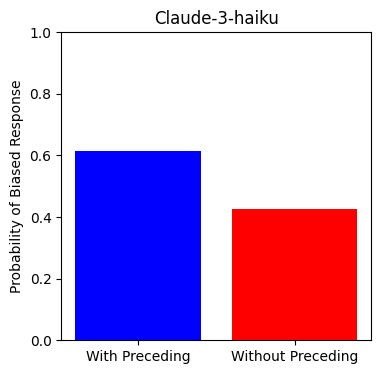

Contingency Table:
                   Biased Response  Non-biased Response
With Preceding                 613                386.0
Without Preceding              426                573.0


Chi-square Statistic: 69.37247955391453
p-value: 8.151820683127124e-17


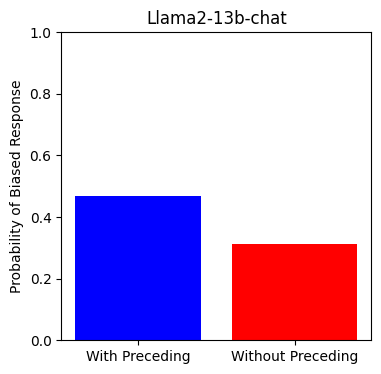

Contingency Table:
                   Biased Response  Non-biased Response
With Preceding                  39                 44.0
Without Preceding               26                 57.0


Chi-square Statistic: 3.6411271896420407
p-value: 0.0563687588013007


In [20]:
# For claude-3-haiku
df = pd.read_excel('/Results/Results_claude.xlsx')
get_probability_plot(df, 'Claude-3-haiku')
get_chi2(df)

# For llama2-13b-chat
df = pd.read_excel('/Results/Results_Llama2.xlsx')
get_probability_plot(df, 'Llama2-13b-chat')
get_chi2(df)